In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import scipy.stats as sts
import statistics

# Описание используемых данных

В первую очередь мы скачали таблицы из датасета по ссылке https://www.kaggle.com/datasets/rohanrao/formula-1-world-championship-1950-2020?select=constructor_results.csv и загрузили их на гитхаб.

В таблице status находится информация о статусе окончания гонки (финишировал ли пилот или по каким-то причинам не смог этого сделать).

В таблице qualifying находится информация о квалификациях: так как каждая квалификация проходит перед гонкой, то в ней указаны id гонки, к которой относится эта квалификация, а также id гонщиков, которые в ней участвовали, места, которые они заняли по итогам квалификации, а также лучшие времена каждого гонщика, показанные в каждом из трех сегментов (q1, q2 и q3).

В таблице drivers находится информация о каждом из гонщиков, а в таблице driver_standings для каждого гонщика указано, какое место он занял в той или иной гонке, а также сколько очков получил.

В таблице constructors находится информация о каждой команде, а в таблице constructor_standings и constructor_results указаны результаты каждой команды в той или иной гонке.

В таблице lap_times для каждого гонщика приведены времена его кругов в той или иной гонке.

В таблице results - информация о результах каждой гонки, а в таблице races - более общая информация о каждой из гонок (в том числе ссылки на сайт википедии про каждую из гонок, которые мы использовали для того, чтобы спарсить данные).

В таблице circuits представлена информация про каждую трассу, на которой проходят или проходили гонки.

Таблица weather - таблица, в которую мы загрузили спарсенные нами данные о погоде во время гонки.

Таблица weather_full - таблица, в которую мы загрузили данные о погоде, которые мы дополнительно спарсили, поэтому эта таблица с погодой не содержит пропусков (Notebook, в котором содержится описание процесса парсинга находится на github).


In [3]:
status = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/status.csv')
quali = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/qualifying.csv')
drivers = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/drivers.csv')
driver_standings = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/driver_standings.csv')
constructors = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/constructors.csv')
constructor_standings = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/constructor_standings.csv')
constructor_results = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/constructor_results.csv')
lap_times = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/lap_times.csv')
results = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/results.csv')
races = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/races.csv')
weather = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/weather.csv')
weather_full = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/weather_full.csv')

# Парсинг информации о погоде в каждой гонке (1)

Мы посчитали необходимым спарсить данные о погоде во время гонок, так как этой информации не было в датасете, который мы выбрали, однако это важный фактор, который вносит хаотичность в гонку. Например, обычно во время дождя происходит большее количество аварий, чем в сухую погоду, а также могут сильнее различаться стратегии, поэтому может быть больше обгонов. Более того, если трасса влажная, на результаты гонки сильнее влияют не характеристики болида, а опыт и талант самого гонщика.

Для того, чтобы спарсить данные о погоде мы использовали статьи про гонки на сайте wikipedia, ссылки на которые находятся в таблице races. Однако в процессе парсинга мы поняли, что информация о погоде там хранится в очень разрозненном виде, поэтому мы классифицировали данные о погоде на несколько категорий: 'wet', 'dry' и 'changing'. В последнюю категорию попали гонки, в описании погоды которых одновременно упоминались маркеры и для дождя, и для сухой погоды. Например, 'rain, later dried out'.

Кроме того, мы хотели отдельно рассмотреть упоминания о ветренной погоде, но в итоге оказалось, что ветреность упоминалась редко, поэтому этот показатель пришлось не учитывать.

Процесс парсинга и код, который мы использовали, содержится в Notebook parsing_weather_1


Мы добавили спарсенные данные по погоде на гитхаб, они находятся по ссылке:
https://raw.githubusercontent.com/pavleke/project-formula-1/main/weather.csv

В столбце weather_main находится информация о погоде, разделенная на категории, а в столбце weather полная информация о погоде.

В столбце 'wind' находится True, если в описании погоды было слово 'windy', и False, если его не было.

Построим облако слов для столбца weather таблицы weather:

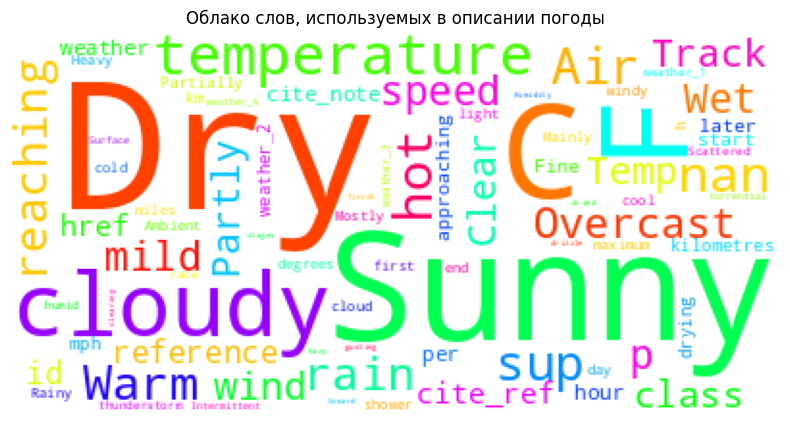

In [4]:
text = ' '.join(i for i in weather['weather'].fillna('nan'))
wordcloud = WordCloud(background_color="white", colormap="hsv", collocations=False).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Облако слов, используемых в описании погоды')
plt.show()

Как видно на этом графике, самое частоиспользуемое слово - 'Sunny', также часто используются слова 'Cloudy' и 'dry', 'overcast'.

Построим также гистограмму распределения категорий погоды

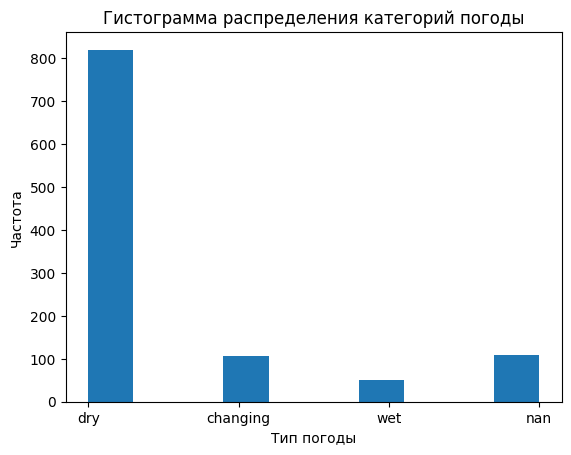

In [5]:
plt.hist(weather['weather_main'].fillna('nan'))
plt.title('Гистограмма распределения категорий погоды')
plt.xlabel('Тип погоды')
plt.ylabel('Частота')
plt.show()

Как видно на гистограмме выше, наиболее распространенная категория погоды - dry

Добавляем информацию о погоде из таблицы weather в таблицу races, используя только столбец weather_main

In [6]:
raceId = pd.DataFrame(races['raceId'])
weather_ = weather.rename({'Unnamed: 0': 'index'}, axis='columns')
weather_.set_index('index')
race_w = raceId.join(weather)
race_w.drop(['Unnamed: 0', 'weather', 'wind'], axis=1, inplace=True)

# Обработка различных таблиц и создание общей таблицы с новыми признаками

Для дальнейшего анализа данных перед нами стояла задача собрать в одну таблицу информацию, которая будет релевантна для предсказания итоговых результатов гонки. Для этого мы сформулировали несколько предположений о том, что может влиять на результаты гонки. Ниже будут описаны некоторые из наших предположений и то, какие признаки мы создавали для последующей проверки этих предположений

## Гипотеза-1

### Среднее время круга для каждого гонщика

**Гипотеза**: гонщики, которые в среднем быстрее едут в течение гонки с большей вероятности выиграют эту гонку

Мы подумали, что для того, чтобы сравнивать между собой различных гонщиков, в том числе гонщиков из одной команды, нам нужно получить среднее время круга в каждой гонке для каждого из гонщиков, которые в ней участвовали. Для этого мы использовали таблицу lap_times и после добавляли получившуюся колонку avLapTimeMill в таблицу results. В этом столбце находится среднее время круга каждого из гонщиков в миллисекундах.

In [7]:
pivot_laps = pd.pivot_table(lap_times, values='milliseconds', index=['raceId', 'driverId'], aggfunc=np.mean)
pivot_laps.rename(columns={'milliseconds': 'avLapTimeMill'}, inplace=True)

In [8]:
results_ = results.set_index(['raceId', 'driverId'])
results_av = results_.merge(pivot_laps, how='left', left_index=True, right_index=True)
results_av.reset_index(inplace=True)

In [9]:
results_av.head()

,raceId,driverId,resultId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,avLapTimeMill
0,1,1,7573,1,1,18,\N,D,20,0.0,58,\N,\N,39,13,1:29.020,214.455,2,97563.758621
1,1,2,7563,2,6,9,10,10,10,0.0,58,+7.085,5662869,48,5,1:28.283,216.245,1,97635.672414
2,1,3,7559,3,16,5,6,6,6,3.0,58,+5.722,5661506,48,1,1:27.706,217.668,1,97612.172414
3,1,4,7558,4,7,10,5,5,5,4.0,58,+4.879,5660663,53,9,1:28.712,215.199,1,97597.637931
4,1,5,7572,1,2,12,\N,R,19,0.0,0,\N,\N,\N,\N,\N,\N,4,NaN


In [10]:
results['milliseconds'].replace('\\N', np.nan, inplace=True)

In [11]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25840 entries, 0 to 25839
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         25840 non-null  int64  
 1   raceId           25840 non-null  int64  
 2   driverId         25840 non-null  int64  
 3   constructorId    25840 non-null  int64  
 4   number           25840 non-null  object 
 5   grid             25840 non-null  int64  
 6   position         25840 non-null  object 
 7   positionText     25840 non-null  object 
 8   positionOrder    25840 non-null  int64  
 9   points           25840 non-null  float64
 10  laps             25840 non-null  int64  
 11  time             25840 non-null  object 
 12  milliseconds     7087 non-null   object 
 13  fastestLap       25840 non-null  object 
 14  rank             25840 non-null  object 
 15  fastestLapTime   25840 non-null  object 
 16  fastestLapSpeed  25840 non-null  object 
 17  statusId    

## Гипотеза-2.1 и гипотеза-2.2

### Количество аварий
### Количество сходов по техническим причинам

**Гипотеза:** существует зависимость между количеством аварий, в которых участвует гонщик и средним количеством обгонов, которые он совершает за гонку.

**Гипотеза:** у команд, для которых характерны частные сходы, меньше шанс на победу

У нас появилась гипотеза, что, например, пилоты с более агрессивным стилем вождения могут как чаще врезаться, так и чаще выигрывать, а кроме того, очевидно, что команды, у которых менее надежные машины будут чаще сходить с дистанции, поэтому реже занимать призовые места. Для того, чтобы проанализировать эти гипотезы, мы решили разделить различные статусы на категории, так как, как видно ниже, изначально в таблице status было слишком много различных категорий

In [12]:
status['status'].unique()

array(['Finished', 'Disqualified', 'Accident', 'Collision', 'Engine',
       'Gearbox', 'Transmission', 'Clutch', 'Hydraulics', 'Electrical',
       '+1 Lap', '+2 Laps', '+3 Laps', '+4 Laps', '+5 Laps', '+6 Laps',
       '+7 Laps', '+8 Laps', '+9 Laps', 'Spun off', 'Radiator',
       'Suspension', 'Brakes', 'Differential', 'Overheating',
       'Mechanical', 'Tyre', 'Driver Seat', 'Puncture', 'Driveshaft',
       'Retired', 'Fuel pressure', 'Front wing', 'Water pressure',
       'Refuelling', 'Wheel', 'Throttle', 'Steering', 'Technical',
       'Electronics', 'Broken wing', 'Heat shield fire', 'Exhaust',
       'Oil leak', '+11 Laps', 'Wheel rim', 'Water leak', 'Fuel pump',
       'Track rod', '+17 Laps', 'Oil pressure', '+42 Laps', '+13 Laps',
       'Withdrew', '+12 Laps', 'Engine fire', 'Engine misfire',
       '+26 Laps', 'Tyre puncture', 'Out of fuel', 'Wheel nut',
       'Not classified', 'Pneumatics', 'Handling', 'Rear wing', 'Fire',
       'Wheel bearing', 'Physical', 'Fuel sys

Мы решили разделить статусы по причинам сходов. Одна из этих категорий - collision (сюда входят аварии и повреждения, которые могут быть получены скорее всего в результате аварий). Эта категория будет нам нужна для того, чтобы в дальнейшем рассмотреть collision rate для каждого гонщика и возможное влияние, которое этот признак оказывает на результаты

В категорию technical включаются причины сходов, которые происходят из-за ненадежности болида, поэтому эту категорию мы будем рассматривать в дальнейшем для того, чтобы проверить гипотезу о влиянии надежности команды на ее результаты

В категорию random включались сходы, которые скорее всего произошли "случайно", то есть, например, из-за того, что на трассе был обломок и кто-то случайно на него наехал или, например, прокол колеса. Такие сходы могли произойти с любым гонщиком, независимо от его команды или стиля вождения, так как обусловлены случайностью

В категорию physical включались сходы по причине физического состояния гонщика, в категорию rules - статусы, которые были обусловлены нарушением каких-либо правил, например, дисквалификация.

В категорию 'out' включались статусы, для которых неизвестно, что стало причиной схода или не участия в гонке. Кроме того, сюда включался такой статус как "fatal accident", потому что мы решили, что неэтично учитывать смертельные аварии в collision rate

В категорию safety включались статусы 'Safety' и 'safety concerns'.

Кроме того, так как среди статусов также есть такие как '+n Laps', мы создали отдельную категорию manylaps в которую включались статусы, в которых n больше 2, потому что очевидно, что в таком случае у гонщика явно случилась какая-то техническая проблема или авария.

In [13]:
collision = ['Collision', 'Broken wing', 'Stalled', 'Eye injury', 'Injury', 'Injured', 'Collision damage', 'Damage', 'Spun off', 'Accident', 'Fatal accident']
technical = ['Engine', 'Gearbox', 'Transmission', 'Clutch', 'Hydraulics', 'Electrical',
       'Radiator', 'Suspension', 'Brakes', 'Differential',
       'Overheating','Mechanical', 'Driver Seat', 'Driveshaft',
       'Retired', 'Fuel pressure', 'Front wing', 'Water pressure',
       'Refuelling', 'Wheel', 'Throttle', 'Steering', 'Technical',
       'Electronics', 'Heat shield fire', 'Oil leak', 'Water leak', 'Fuel pump',
       'Track rod', 'Oil pressure', 'Engine fire', 'Engine misfire', 'Out of fuel', 'Wheel nut',
       'Not classified', 'Pneumatics', 'Handling', 'Rear wing', 'Fire',
       'Wheel bearing', 'Fuel system', 'Oil line', 'Fuel rig',
       'Launch control', 'Fuel', 'Power loss', 'Vibrations', 'Drivetrain', 'Ignition',
       'Chassis', 'Battery', 'Halfshaft', 'Crankshaft', 'Alternator',
       'Safety belt', 'Oil pump', 'Fuel leak',
       'Injection', 'Distributor', 'Turbo', 'CV joint', 'Water pump',
       'Spark plugs', 'Fuel pipe', 'Oil pipe', 'Axle', 'Water pipe',
       'Magneto', 'Supercharger', 'Power Unit', 'ERS',
       'Brake duct', 'Seat', 'Undertray','Cooling system']
random = ['Tyre', 'Puncture', 'Wheel rim', 'Tyre puncture', 'Debris']
physical = ['Exhaust', 'Physical', 'Driver unwell', 'Illness']
rules = ['Disqualified', '107% Rule', 'Underweight']
out = ['Did not qualify', 'Not restarted', 'Withdrew', 'Excluded', 'Did not prequalify']
safety = ['Safety', 'Safety concerns']
finished = ['Finished']
manylaps = ['+3 Laps', '+4 Laps', '+5 Laps', '+6 Laps',
       '+7 Laps', '+8 Laps', '+9 Laps', '+11 Laps', '+17 Laps', '+42 Laps', '+13 Laps',
       '+12 Laps', '+26 Laps', '+10 Laps', '+14 Laps', '+15 Laps',
       '+25 Laps', '+18 Laps', '+22 Laps', '+16 Laps', '+24 Laps',
       '+29 Laps', '+23 Laps', '+21 Laps', '+44 Laps',
       '+30 Laps', '+19 Laps', '+46 Laps', '+20 Laps', '+49 Laps', '+38 Laps']
status.loc[status['status'].isin(collision), 'status_short'] = 'collision'
status.loc[status['status'].isin(technical), 'status_short'] = 'technical'
status.loc[status['status'].isin(random), 'status_short'] = 'random'
status.loc[status['status'].isin(physical), 'status_short'] = 'physical'
status.loc[status['status'].isin(rules), 'status_short'] = 'rules'
status.loc[status['status'].isin(out), 'status_short'] = 'out'
status.loc[status['status'].isin(safety), 'status_short'] = 'safety'
status.loc[status['status'].isin(finished), 'status_short'] = 'finished'
status.loc[status['status'].isin(manylaps), 'status_short'] = 'manylaps'
status.loc[status['status'].isin(['+1 Lap']), 'status_short'] = '+1 Lap'
status.loc[status['status'].isin(['+2 Laps']), 'status_short'] = '+2 Laps'

In [14]:
status.set_index('statusId', inplace=True)

Объединим нашу таблицу results_av, в которой содержутся results и созданный нами признак avLapTimeMill, и таблицу status

In [15]:
results_st_av = results_av.merge(status, how='left', left_on='statusId', right_index=True)

In [16]:
results_st_av.head()

,raceId,driverId,resultId,constructorId,number,grid,position,positionText,positionOrder,points,...,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,avLapTimeMill,status,status_short
0,1,1,7573,1,1,18,\N,D,20,0.0,...,\N,\N,39,13,1:29.020,214.455,2,97563.758621,Disqualified,rules
1,1,2,7563,2,6,9,10,10,10,0.0,...,+7.085,5662869,48,5,1:28.283,216.245,1,97635.672414,Finished,finished
2,1,3,7559,3,16,5,6,6,6,3.0,...,+5.722,5661506,48,1,1:27.706,217.668,1,97612.172414,Finished,finished
3,1,4,7558,4,7,10,5,5,5,4.0,...,+4.879,5660663,53,9,1:28.712,215.199,1,97597.637931,Finished,finished
4,1,5,7572,1,2,12,\N,R,19,0.0,...,\N,\N,\N,\N,\N,\N,4,NaN,Collision,collision


Проанализируем встречаемость различных статусов (как в колонке status, так и в колонке status_short) с помощью облака слов

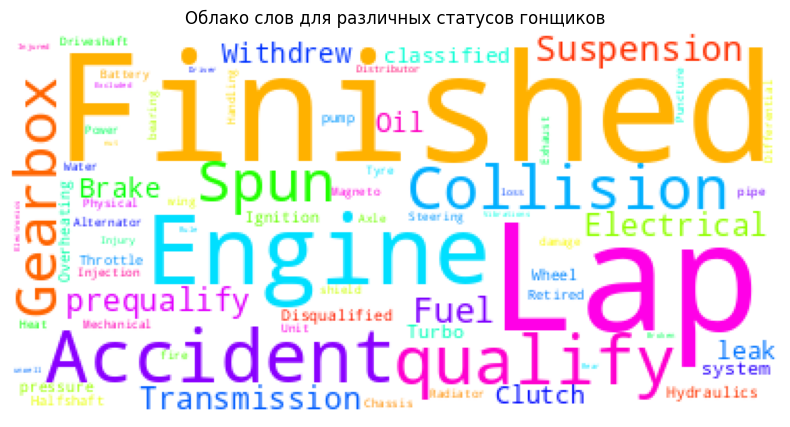

In [17]:
text = ' '.join(i for i in results_st_av['status'])
wordcloud = WordCloud(background_color="white", colormap="hsv", collocations=False).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Облако слов для различных статусов гонщиков')
plt.show()

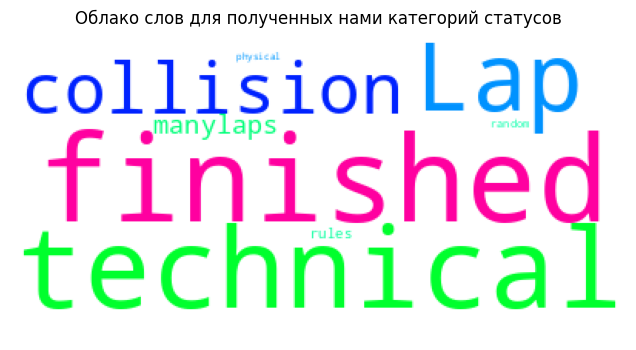

In [18]:
text = ' '.join(i for i in results_st_av.status_short)
wordcloud = WordCloud(background_color="white", colormap="hsv", collocations=False).generate(text)
plt.figure(figsize=(8,4))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Облако слов для полученных нами категорий статусов')
plt.show()

Кроме того, построим гистограмму распределения status_short. Как видно на графиках, наиболее популярные категории - finished и technical

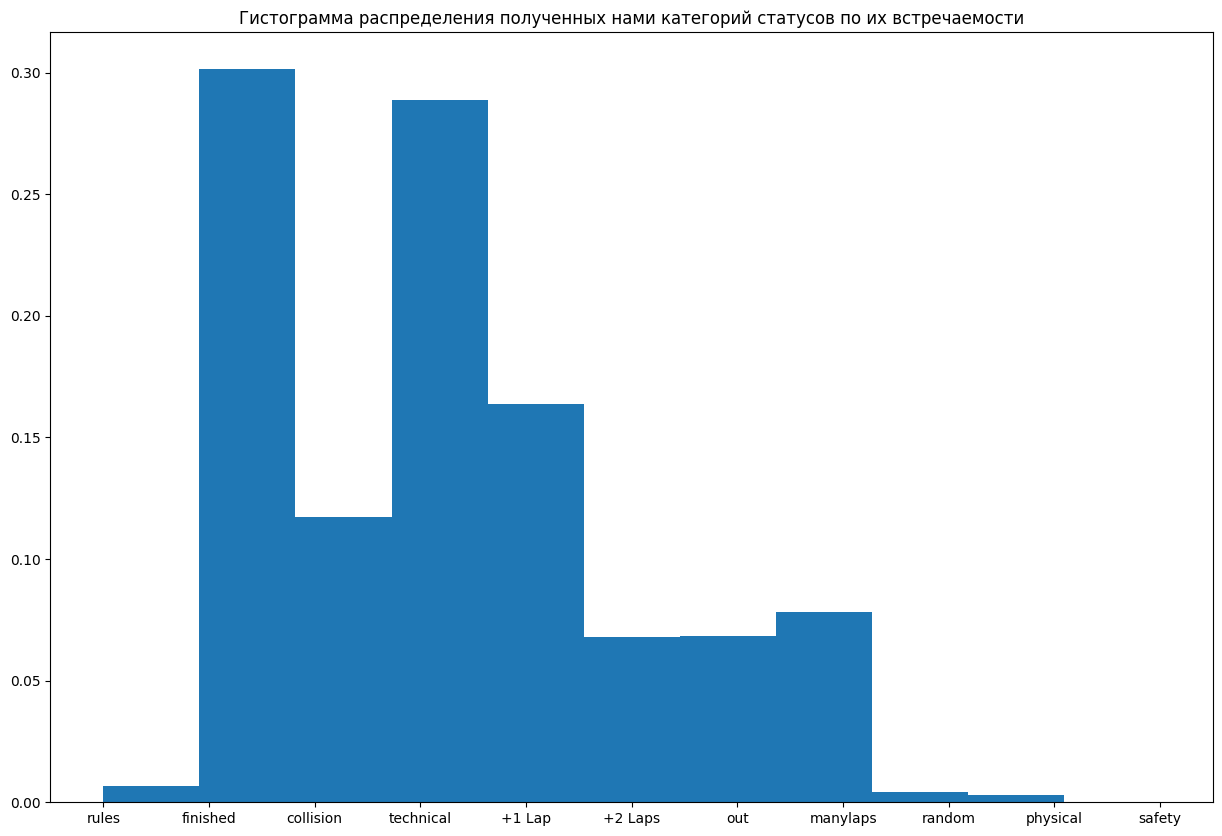

In [19]:
plt.figure(figsize=(15, 10))
plt.hist(results_st_av['status_short'], bins=11, rwidth=2, density=True)
plt.title('Гистограмма распределения полученных нами категорий статусов по их встречаемости')
plt.show()

Кроме того, мы добавили погоду в получившуюся таблицу results_st_av и удалили из нее столбцы, которые скорее всего не понадобятся нам для дальнейшего анализа. Таким образом получилась таблица st_av_w.

In [20]:
results_st_av_w = results_st_av.merge(race_w, how='left', on='raceId')

In [21]:
st_av_w = results_st_av_w.drop(['number', 'positionText', 'position', 'points', 'statusId', 'fastestLap', 'fastestLapSpeed'], axis=1)

In [22]:
st_av_w.head()

,raceId,driverId,resultId,constructorId,grid,positionOrder,laps,time,milliseconds,rank,fastestLapTime,avLapTimeMill,status,status_short,weather_main
0,1,1,7573,1,18,20,58,\N,\N,13,1:29.020,97563.758621,Disqualified,rules,dry
1,1,2,7563,2,9,10,58,+7.085,5662869,5,1:28.283,97635.672414,Finished,finished,dry
2,1,3,7559,3,5,6,58,+5.722,5661506,1,1:27.706,97612.172414,Finished,finished,dry
3,1,4,7558,4,10,5,58,+4.879,5660663,9,1:28.712,97597.637931,Finished,finished,dry
4,1,5,7572,1,12,19,0,\N,\N,\N,\N,NaN,Collision,collision,dry


Для того, чтобы в дальнейшем проверить нашу гипотезу, нужно создать два новых столбца: во-первых, посчитать процент технических сходов для каждой команды, а, во-вторых, посчитать процент аварий для каждого гонщика

## Гипотеза 3

### Среднее время квалификации для каждой команды

**Гипотеза:** Некоторые гонщики могут выступать стабильно лучше, чем их напарники по команде, поэтому, даже если у этой команды лучшая скорость среди всех остальных, шансы на победу более медленного гонщика ниже, чем шансы на победу у более быстрого гонщика из этой команды

Мы хотели проверить, как в среднем выступают гонщики одной команды в сравнении друг с другом. Для этого мы решили создать столбец avTeamLapTimeMill, в котором находится среднее время круга каждой команды в каждой гонке.

Кроме того, мы решили добавить circuitId в нашу таблицу, так как этот признак понадобится нам в дальнейшем. cir - таблица, с добавленным circuitId, в которую мы будем добавлять признак avTeamQualiTime.

In [23]:
race_cir = races[['raceId', 'circuitId']]
cir = st_av_w.set_index('raceId').join(race_cir.set_index('raceId'), how='left')
cir.reset_index(inplace=True)
cir.set_index(['raceId', 'constructorId'], inplace=True)

In [24]:
cir['AvTeamLapTimeMill'] = pd.DataFrame(cir.groupby(['raceId', 'constructorId'])['avLapTimeMill'].mean())

In [25]:
cir_av_st_w = cir.reset_index()
cir_av_st_w.set_index(['raceId', 'driverId'], inplace=True)

In [26]:
cir_av_st_w.head()

constructorId  resultId  grid  positionOrder  laps    time  \
raceId driverId                                                               
1      1                     1      7573    18             20    58      \N   
       2                     2      7563     9             10    58  +7.085   
       3                     3      7559     5              6    58  +5.722   
       4                     4      7558    10              5    58  +4.879   
       5                     1      7572    12             19     0      \N   

                milliseconds rank fastestLapTime  avLapTimeMill        status  \
raceId driverId                                                                 
1      1                  \N   13       1:29.020   97563.758621  Disqualified   
       2             5662869    5       1:28.283   97635.672414      Finished   
       3             5661506    1       1:27.706   97612.172414      Finished   
       4             5660663    9       1:28.712   97597.637931      Finished   
       5                  \N   \N             \N            NaN     Collision   

                status_short weather_main  circuitId  AvTeamLapTimeMill  
raceId driverId                                                          
1      1               rules          dry          1       97563.758621  
       2            finished          dry          1       96398.181661  
       3            finished          dry          1       94717.203854  
       4            finished          dry          1       99681.610632  
       5           collision          dry          1       97563.758621

## Гипотеза-4

### Время квалификации для каждого гонщика

**Гипотеза:** скорость гонщика в квалификации влияет на его шансы на победу

Кроме того, скорость каждого гонщика и каждой команды отлично показывает квалификация. При этом иногда результат квалификации не отражает в полной мере скорость пилота - например, он может быть наказан за какое-либо нарушение, поэтому его стартовая позиция (grid) будет отличаться от итоговой позиции в квалификации, или скорость машины позволяла ехать быстрее, но он, например, ошибся в последнем сегменте квалификации. Поэтому мы решили смотреть не только на результаты квалификации, но и на времена гонщиков.

Для того, чтобы в будущем сравнивать скорость различных гонщиков в квалификации, нам нужно было перевести лучшие времена каждого сегмента в квалификации в миллисекунды, так как тип данных, который был присвоен этим колонкам в таблице qualifying не подходил для сравнения. Для этого мы написали следующие функции:

In [27]:
### Функции для перевода времени в миллисекунды

def millisec(x):
    if len(x) == 3:
        min_ = int(x[0]) * 60000
        sec_ = int(x[1]) * 1000
        millis_ = int(x[2])
        y = min_ + sec_ + millis_
    else:
        y = 0
    return y

timing = np.vectorize(millisec)

def separating(qual):
    time = np.array(quali[qual].fillna('no_time'))
    time = time.astype(str)
    time = np.char.replace(time, '.', ':')
    time = np.char.split(time, sep =':')
    time = timing(time)
    return(time)

Используем эти функции на таблице quali

In [28]:
quali['q1Mill'] = separating('q1')
quali['q2Mill'] = separating('q2')
quali['q3Mill'] = separating('q3')

После этого мы удалили ненужные значения и задали новые индексы для того, чтобы потом соединить эту таблицу с таблицей cir_av_st_w

In [29]:
quali_mill = quali.drop(['number', 'q1', 'q2', 'q3', 'qualifyId'], axis=1)
quali_mill.set_index(['raceId', 'driverId'], inplace=True)

Как видно выше, таблица cir_av_st_w - таблица с добавленным avLapTimeMill, к которой мы будем добавлять времена каждого гонщика в квалификации в миллисекундах, которые мы получили выше в таблице quali_mill.

Таблица с добавленными временами в квалификации будет называться cir_q_av_st_w

In [30]:
q = cir_av_st_w.reset_index().merge(quali_mill.reset_index(), how='left', on=['raceId', 'driverId'])

In [31]:
cir_q = q.drop('constructorId_y', axis=1)
cir_q_av_st_w = cir_q.rename(columns={'constructorId_x': 'constructorId', 'position': 'res_q'})

In [32]:
cir_q_av_st_w.head()

,raceId,driverId,constructorId,resultId,grid,positionOrder,laps,time,milliseconds,rank,...,avLapTimeMill,status,status_short,weather_main,circuitId,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill
0,1,1,1,7573,18,20,58,\N,\N,13,...,97563.758621,Disqualified,rules,dry,1,97563.758621,15.0,86454.0,0.0,0.0
1,1,2,2,7563,9,10,58,+7.085,5662869,5,...,97635.672414,Finished,finished,dry,1,96398.181661,11.0,85827.0,85504.0,0.0
2,1,3,3,7559,5,6,58,+5.722,5661506,1,...,97612.172414,Finished,finished,dry,1,94717.203854,5.0,85846.0,85123.0,86973.0
3,1,4,4,7558,10,5,58,+4.879,5660663,9,...,97597.637931,Finished,finished,dry,1,99681.610632,12.0,86026.0,85605.0,0.0
4,1,5,1,7572,12,19,0,\N,\N,\N,...,NaN,Collision,collision,dry,1,97563.758621,14.0,86184.0,85726.0,0.0


## Гипотеза-5

### Дебютная гонка для каждого гонщика

**Гипотеза:** у неопытных гонщиков чаще риск аварий и результаты хуже, чем у более опытных напарников, поэтому их шансы на победу ниже

Так как мы планируем сравнивать гонщиков, мы решили добавить признак, который будет учитывать, является ли эта гонка первой в карьере гонщика. Возможно, при последующем анализе мы заменим этот признак на то, является ли этот сезон первым в карьере гонщика.

Для этого сначала мы создаем таблицу, в которой для каждого гонщика указана его дебютная гонка. (Таблица d)

In [33]:
race = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/races.csv')
#тут создаем новый id каждой гонки, который зависит от даты проведения гонки
results = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/results.csv')
new = race.sort_values(by='date')
new['newid'] = np.arange(1, len(new)+1)
#добавляем в результаты новый id гонок, чтобы по нему искать гонщиков
new_result = results.merge(new[['raceId', 'newid']],right_on='raceId', left_on='raceId')
#вытаскиваем из new_results только гонщиков и айди их дебютных гонок (функция min)
new_id = pd.DataFrame(new_result.groupby('driverId')['newid'].min())
ind=new_id['newid']
# вот тут результат: индекс это айди гонщика, в столбцах дебютная гонка
n = new[['newid', 'raceId', 'name', 'date']].set_index('newid')
new_id.reset_index(inplace=True)
new_id.set_index('newid', inplace=True)
drivers_debut = new_id.join(n, how='left')
drivers_debut.reset_index(inplace=True)
drivers_debut.set_index('driverId', inplace=True)
d = drivers_debut[['raceId', 'name']]

Мы сохранили таблицу new на github, так как в дальнейшем она нам понадобится

In [34]:
new.to_csv('new.csv')

Добавим информацию о дебюте гонщика в нашу рабочую таблицу, а также переименуем и удалим некоторые колонки

In [35]:
cir_q_av_st_w_ = cir_q_av_st_w.merge(d, how='left', left_on='driverId', right_index=True)
cir_q_av_st_w_.rename(columns={'raceId_x':'raceId', 'raceId_y':'debut_raceId'}, inplace=True)
cir_q_av_st_w_r = cir_q_av_st_w_.drop('name', axis=1)

Добавим признак is_debut в нашей рабочей таблице, который будет говорить нам True, если данная гонка дебютная для гонщика. Итоговая таблица будет называться cir_q_av_st_w_r

In [36]:
cir_q_av_st_w_r = cir_q_av_st_w_r.astype({'debut_raceId':'int'})
cir_q_av_st_w_r['is_debut'] = (cir_q_av_st_w_r['raceId']==cir_q_av_st_w_r['debut_raceId'])

In [37]:
cir_q_av_st_w_r.head()

,raceId,driverId,constructorId,resultId,grid,positionOrder,laps,time,milliseconds,rank,...,status_short,weather_main,circuitId,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut
0,1,1,1,7573,18,20,58,\N,\N,13,...,rules,dry,1,97563.758621,15.0,86454.0,0.0,0.0,36,False
1,1,2,2,7563,9,10,58,+7.085,5662869,5,...,finished,dry,1,96398.181661,11.0,85827.0,85504.0,0.0,158,False
2,1,3,3,7559,5,6,58,+5.722,5661506,1,...,finished,dry,1,94717.203854,5.0,85846.0,85123.0,86973.0,53,False
3,1,4,4,7558,10,5,58,+4.879,5660663,9,...,finished,dry,1,99681.610632,12.0,86026.0,85605.0,0.0,141,False
4,1,5,1,7572,12,19,0,\N,\N,\N,...,collision,dry,1,97563.758621,14.0,86184.0,85726.0,0.0,36,False


## Гипотеза-6

### Средняя позиция команды на финише в каждом сезоне

**Гипотеза:** результат гонщика в отдельно взятой гонки зависит от того, насколько успешными были результаты его команды в других гонках этого сезона

Так как часто случается так, что некоторые из команд могут построить машину, которая будет существенно быстрее других, мы решили оценивать среднюю позицию команды на финише в каждом сезоне. Эта информация представлена в таблице cir_years_q_av_st_w_r в столбце avPosTeam

Для оценки гипотезы посчитаем корреляцию между результатом гонки и средним результатом его команды в этом сезоне (исключая эту гонку). Для начала расчитаем переменную avPosTeam, показывающую среднюю позицию команды за сезон.

In [38]:
years = races[['raceId', 'year']]
cir_years = cir_q_av_st_w_r.merge(years, on='raceId')
cir_y = pd.DataFrame(cir_years.groupby(['year', 'constructorId'])['positionOrder'].mean())
cir_y.rename(columns={'positionOrder': 'avPosTeam'}, inplace=True)
cir_years.set_index(['year', 'constructorId'], inplace=True)
c = cir_years.join(cir_y)
c.reset_index(inplace=True)
cir_years_q_av_st_w_r = c.sort_values(by=['raceId', 'driverId', 'constructorId'])

*Теперь* учтем, что в среднем также учитывается результат гонки, наличие связи с которой мы хотим проверить. Поэтому нужно исключить значение самой гонки из расчета средней позиции команды за этот сезон. Переменная CorrAvPosTeam показывает скорректированную среднюю позицию команды за сезон.

In [39]:
cir_years_q_av_st_w_r['1'] = np.ones(len(cir_years_q_av_st_w_r['year']))
All_races_in_a_season = cir_years_q_av_st_w_r.groupby(['year', 'constructorId']).sum()['1']
df2 = cir_years_q_av_st_w_r.set_index(['year', 'constructorId'])
df3 = pd.merge(All_races_in_a_season, df2, left_index=True, right_index=True)
df3 = df3.reset_index(drop=True)
df3.rename(columns = {'1_x':'NumTeamRacesInSeason'}, inplace = True )
df3['CorrAvPosTeam'] = (df3['avPosTeam'] * df3['NumTeamRacesInSeason'] - df3['positionOrder']) / ( df3['NumTeamRacesInSeason'] - 1)
df3 = df3.drop(columns = ['1_y'],axis = 1)
df3.head()

<ipython-input-39-a6e179c370ae>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  All_races_in_a_season = cir_years_q_av_st_w_r.groupby(['year', 'constructorId']).sum()['1']


,NumTeamRacesInSeason,raceId,driverId,resultId,grid,positionOrder,laps,time,milliseconds,rank,...,circuitId,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut,avPosTeam,CorrAvPosTeam
0,15.0,834,633,20053,6,8,63,\N,\N,\N,...,6,NaN,NaN,NaN,NaN,NaN,834,True,9.466667,9.571429
1,15.0,834,647,20047,7,2,99,\N,\N,\N,...,6,NaN,NaN,NaN,NaN,NaN,834,True,9.466667,10.000000
2,15.0,834,687,20065,21,20,0,\N,\N,\N,...,6,NaN,NaN,NaN,NaN,NaN,834,True,9.466667,8.714286
3,15.0,834,793,20049,9,4,97,\N,\N,\N,...,6,NaN,NaN,NaN,NaN,NaN,834,True,9.466667,9.857143
4,15.0,836,633,20115,4,16,9,\N,\N,\N,...,66,NaN,NaN,NaN,NaN,NaN,834,False,9.466667,9.000000


Постоим диаграмму рассеяния двух исследуемых переменных и рассчитаем корреляцию. По диаграмме видно, что есть положительная линейная связь.

<Axes: xlabel='positionOrder', ylabel='CorrAvPosTeam'>

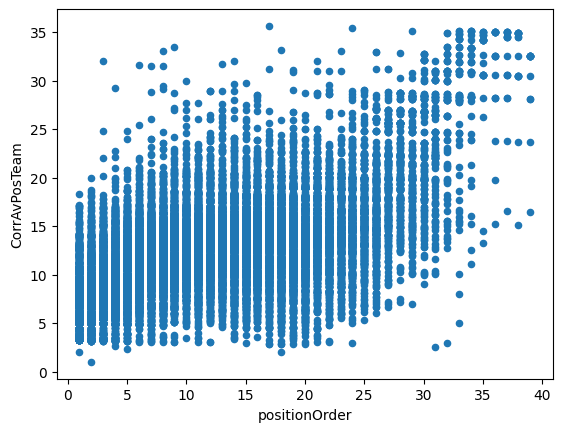

In [40]:
df3.plot.scatter('positionOrder', 'CorrAvPosTeam', s=None, c=None)

In [41]:
corr = df3['positionOrder'].corr(df3['CorrAvPosTeam'])
corr

0.563292125570801

Сформулируем гипотезы о связи между выступлением команды гонщика в этом сезоне и его выступлением:

$H0: r(positionOrder, CorrAvPosTeam) = 0$

$H1: r(positionOrder, CorrAvPosTeam) \neq 0$

In [42]:
t_obs = corr*np.sqrt(len(df3['positionOrder']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(df3['positionOrder'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции  отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0, то есть корреляция не является значимой')

Наблюдаемое t = 109.58410007741658
Реальное t на уровне значимости 0.05 = 1.6449126030376522
Гипотеза об отсутствии корреляции  отвергается в пользу альтернативной на уровне значимости 0.05


Вывод: между выступлениями команды в этом сезоне и конкретным выступлением гонщика есть корреляция. Это может быть связано с тем, что в некоторых сезонах команда готова лучше (например, более подходящий современный болид), а в некоторых - хуже.

## Гипотеза-7

### Средняя позиция гонщика на финише в каждом сезоне

**Гипотеза:**  результат гонщика в отдельно взятой гонки зависит от того, насколько успешными были его результаты в других гонках этого сезона

Кроме того, нам также нужно сравнивать и гонщиков внутри одной команды или гонщиков внутри группы команд, которые борются между собой. Для этого будем считать среднюю позицию гонщика на финише в каждый сезон. Информация об этом будет находится в таблице cir_years_d_q_av_st_w_r в столбце avPosDriver

In [45]:
years = races[['raceId', 'year']]
cir_years = cir_q_av_st_w_r.merge(years, on='raceId')
cir_y = pd.DataFrame(cir_years.groupby(['year', 'driverId'])['positionOrder'].mean())
cir_y.rename(columns={'positionOrder': 'avPosDriver'}, inplace=True)
cir_years.set_index(['year', 'driverId'], inplace=True)
c = cir_years.join(cir_y)
c.reset_index(inplace=True)
cir_years_q_av_st_w_r = c.sort_values(by=['raceId', 'driverId', 'constructorId'])

Теперь учтем, что в среднем также учитывается результат гонки, наличие связи с которой мы хотим проверить. Поэтому нужно исключить значение самой гонки из расчета средней позиции гонщика за этот сезон. Переменная CorrAvPosDriver показывает скорректированную среднюю позицию гонщика за сезон.

In [47]:
cir_years_q_av_st_w_r['1'] = np.ones(len(cir_years_q_av_st_w_r['year']))
All_races_in_a_season_by_driver = cir_years_q_av_st_w_r.groupby(['year', 'driverId']).sum()['1']
df2 = cir_years_q_av_st_w_r.set_index(['year', 'driverId'])
df3 = pd.merge(All_races_in_a_season_by_driver, df2, left_index=True, right_index=True)
df3 = df3.reset_index(drop=True)
df3.rename(columns = {'1_x':'NumDriverRacesInSeason'}, inplace = True )
df3['CorrAvPosDriver'] = (df3['avPosDriver'] * df3['NumDriverRacesInSeason'] - df3['positionOrder']) / ( df3['NumDriverRacesInSeason'] - 1)
df3 = df3.drop(columns = ['1_y'],axis = 1)
df3.head()

<ipython-input-47-0fcad40e91bf>:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  All_races_in_a_season_by_driver = cir_years_q_av_st_w_r.groupby(['year', 'driverId']).sum()['1']


,NumDriverRacesInSeason,raceId,constructorId,resultId,grid,positionOrder,laps,time,milliseconds,rank,...,circuitId,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut,avPosDriver,CorrAvPosDriver
0,2.0,834,141,20061,13,16,0,\N,\N,\N,...,6,NaN,NaN,NaN,NaN,NaN,834,True,18.5,21.0
1,2.0,839,141,20170,12,21,13,\N,\N,\N,...,14,NaN,NaN,NaN,NaN,NaN,834,False,18.5,16.0
2,2.0,834,105,20055,3,10,1,\N,\N,\N,...,6,NaN,NaN,NaN,NaN,NaN,834,True,14.0,18.0
3,2.0,838,105,20149,8,18,3,\N,\N,\N,...,55,NaN,NaN,NaN,NaN,NaN,834,False,14.0,10.0
4,2.0,834,87,20064,20,19,0,\N,\N,\N,...,6,NaN,NaN,NaN,NaN,NaN,834,True,13.5,8.0


Постоим диаграмму рассеяния двух исследуемых переменных и рассчитаем корреляцию. По диаграмме видно, что есть положительная линейная связь.

<Axes: xlabel='positionOrder', ylabel='CorrAvPosDriver'>

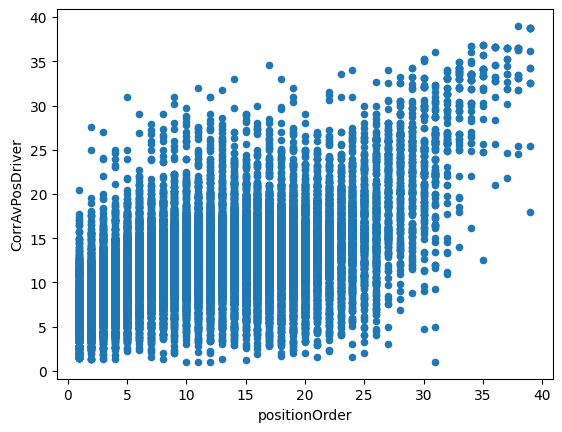

In [48]:
df3.plot.scatter('positionOrder', 'CorrAvPosDriver', s=None, c=None)

In [49]:
corr = df3['positionOrder'].corr(df3['CorrAvPosDriver'])
corr

0.5677502684486204

Сформулируем гипотезы о связи между другими выступлением гонщика в этом сезоне и его выступлением в конкретной гонке:

$H0: r(positionOrder, CorrAvPosTeam) = 0$

$H1: r(positionOrder, CorrAvPosTeam) \neq 0$

In [50]:
t_obs = corr*np.sqrt(len(df3['positionOrder']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(df3['positionOrder'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции  отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0, то есть корреляция не является значимой')

Наблюдаемое t = 110.86156042075797
Реальное t на уровне значимости 0.05 = 1.6449126030376522
Гипотеза об отсутствии корреляции  отвергается в пользу альтернативной на уровне значимости 0.05


Вывод: между выступлениями гонщика в этом сезоне и его конкретным выступлением есть корреляция. Это может быть связано с тем, что в некоторых сезонах гонщик готов лучше, а в некоторых - хуже.

## Гипотеза-8

### Обгонность каждой трассы

**Гипотеза:** на некоторых трассах обгонять сложнее, чем на других, поэтому результаты гонки на этих трассах сильнее зависят от результатов квалификации

Мы хотели проверить, правда ли, что на некоторых трассах обгоны случаются чаще, чем на других. Для этого мы будем сравнивать стартовую позицию каждого гонщика (grid) с его итоговой позицией на финише (positionOrder) на каждой трассе. В результате получим значение overtaking.


In [51]:
over = cir_years_d_q_av_st_w_r[['circuitId', 'constructorId', 'grid', 'positionOrder']]
over = over[over.positionOrder != 'None']
over = over[over.positionOrder != '\\N']

over['positionOrder'] = over.positionOrder.astype(int)
over['overtaking'] = abs(over.grid - over.positionOrder)
year_over = over
over = over.groupby('circuitId').mean()
over = over.drop(columns=['grid', 'positionOrder', 'constructorId'])
over_ = over

In [52]:
over_.head()

,overtaking
circuitId,
1,5.135688
2,4.771845
3,3.682500
4,4.773296
5,3.510417


Построим диаграмму распределения количества "обгонов" (под обгоном мы подразумеваем среднее изменение позиции гонщика относительно его стартовой позиции) по различным трассам

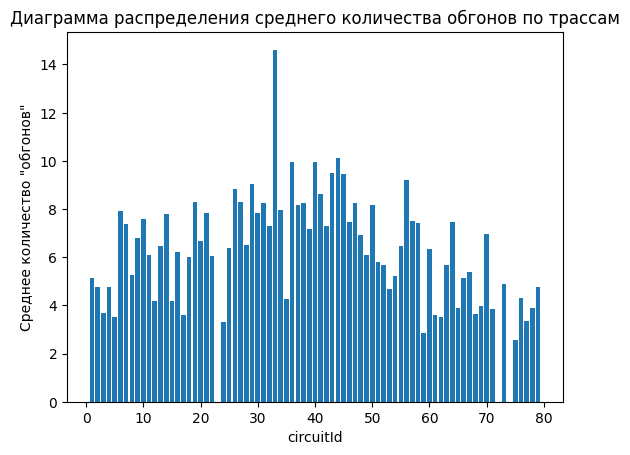

In [53]:
plt.bar(over.index, over.overtaking)
plt.xlabel('circuitId')
plt.ylabel('Среднее количество "обгонов"')
plt.title('Диаграмма распределения среднего количества обгонов по трассам')
plt.show()

Столбец со средней обгонностью каждой трассы называется overCir в общей таблице cir_years_d_q_av_st_q_r_over

In [54]:
cir_years_d_q_av_st_q_r_over = cir_years_q_av_st_w_r.merge(over, how='left', left_on='circuitId', right_index=True)
cir_years_d_q_av_st_q_r_over.rename(columns={'overtaking': 'overCir'}, inplace=True)

In [55]:
cir_years_d_q_av_st_q_r_over.head()

,year,driverId,raceId,constructorId,resultId,grid,positionOrder,laps,time,milliseconds,...,AvTeamLapTimeMill,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut,avPosDriver,1,overCir
19983,2009,1,1,1,7573,18,20,58,\N,\N,...,97563.758621,15.0,86454.0,0.0,0.0,36,False,9.705882,1.0,5.135688
20000,2009,2,1,2,7563,9,10,58,+7.085,5662869,...,96398.181661,11.0,85827.0,85504.0,0.0,158,False,10.470588,1.0,5.135688
20017,2009,3,1,3,7559,5,6,58,+5.722,5661506,...,94717.203854,5.0,85846.0,85123.0,86973.0,53,False,8.235294,1.0,5.135688
20034,2009,4,1,4,7558,10,5,58,+4.879,5660663,...,99681.610632,12.0,86026.0,85605.0,0.0,141,False,9.823529,1.0,5.135688
20051,2009,5,1,1,7572,12,19,0,\N,\N,...,97563.758621,14.0,86184.0,85726.0,0.0,36,False,11.117647,1.0,5.135688


## Гипотеза-9

### В различные сезоны в среднем разное количество обгонов

**Гипотеза:** в разные сезоны могут действовать различные технические регламенты, поэтому в среднем в некоторые сезоны обгонять сложнее, чем в другие

Сделаем операции аналогичные операциям, которые описывались в предыдущем пункте, для оценки среднего количества обгонов по годам, так как в разные периоды времени были различные регламенты, поэтому количество обгонов могло различаться в зависимости от этого.

In [56]:
over = cir_years_d_q_av_st_w_r[['circuitId', 'constructorId', 'grid', 'positionOrder', 'year']]
over = over[over.positionOrder != 'None']
over = over[over.positionOrder != '\\N']

over['positionOrder'] = over.positionOrder.astype(int)
over['overtaking'] = abs(over.grid - over.positionOrder)
year_over = over

year_over = year_over.groupby('year').mean()
year_over = year_over.drop(columns=['grid', 'positionOrder', 'constructorId', 'circuitId'])
year_over_ = year_over

In [57]:
year_over_.head()

,overtaking
year,
1950,6.337500
1951,5.061453
1952,7.786047
1953,6.333333
1954,7.056522


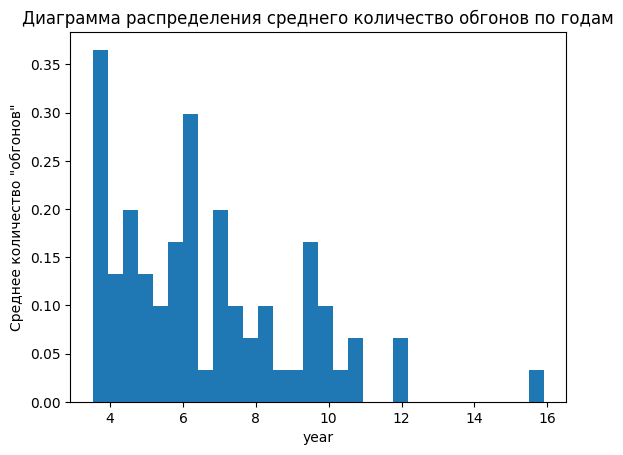

In [58]:
plt.hist(year_over.overtaking, density=True, bins=30)
plt.xlabel('year')
plt.ylabel('Среднее количество "обгонов"')
plt.title('Диаграмма распределения среднего количество обгонов по годам')
plt.show()

In [59]:
cir_years_d_q_av_st_q_r_over_ = cir_years_d_q_av_st_q_r_over.reset_index().merge(year_over, how='left', left_on='year', right_index=True)
cir_years_d_q_av_st_q_r_over_.rename(columns={'overtaking': 'overYear'}, inplace=True)

In [60]:
cir_years_d_q_av_st_q_r_over_.head()

,index,year,driverId,raceId,constructorId,resultId,grid,positionOrder,laps,time,...,res_q,q1Mill,q2Mill,q3Mill,debut_raceId,is_debut,avPosDriver,1,overCir,overYear
0,19983,2009,1,1,1,7573,18,20,58,\N,...,15.0,86454.0,0.0,0.0,36,False,9.705882,1.0,5.135688,3.858824
1,20000,2009,2,1,2,7563,9,10,58,+7.085,...,11.0,85827.0,85504.0,0.0,158,False,10.470588,1.0,5.135688,3.858824
2,20017,2009,3,1,3,7559,5,6,58,+5.722,...,5.0,85846.0,85123.0,86973.0,53,False,8.235294,1.0,5.135688,3.858824
3,20034,2009,4,1,4,7558,10,5,58,+4.879,...,12.0,86026.0,85605.0,0.0,141,False,9.823529,1.0,5.135688,3.858824
4,20051,2009,5,1,1,7572,12,19,0,\N,...,14.0,86184.0,85726.0,0.0,36,False,11.117647,1.0,5.135688,3.858824


В дальнейшем мы будем работать с этой таблицей.

## Гипотезы 10

### 10.1 Погода влияет на количество обгонов в гонке

**10.1.1**

Например, мы предполагаем, что в дождливую погоду обгонов (или изменений позиций относительно старта) больше, чем в сухую, так как стратегии могут сильнее различаться, а также условия гонки сложнее и из-за этого может увеличиться количество сходов

**10.1.2**

Однако, мы также предполагаем, что в гонках, в которых меняются условия (у нас такие гонки относятся в категорию changing) обгонов может быть больше, чем в дождливую, так как условия еще сложнее как для стратегов, так и для гонщиков, так как в процессе гонки происходят изменения погоды и стратегам нужно быстро принимать решения насчет того, какой тип резины выбрать, а гонщики могут не успеть приспособиться к меняющимся условиям и из-за этого чаще вылетать. Поэтому те гонщики или команды, которые умеют справляться со сложными условиями могут отыграть очень много позиций

### 10.2 Погода влияет на количество аварий в гонке

**10.2.1**

Мы предполагаем, что в дождливую погоду аварий, которые относятся в категорию collision, может быть больше, чем в сухую погоду, так как гонщикам сложнее справляться с управлением во время дождя

**10.2.2**

Кроме того, мы предполагаем, что в меняющуюся погоду может быть больше аварий, чем в дождливую, так как условия сложнее

# Работа с получившейся таблицей

In [61]:
working = cir_years_d_q_av_st_q_r_over_

Сохраним эту таблицу на github, чтобы в дальнейшем не приходилось запускать остальной код для работы с этой таблицей

In [62]:
working.to_csv('working.csv')

## Устранение пропусков в данных

In [63]:
working = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/working.csv')
working.replace('\\N', np.nan, inplace=True)
working.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25840 entries, 0 to 25839
Data columns (total 28 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         25840 non-null  int64  
 1   year               25840 non-null  int64  
 2   driverId           25840 non-null  int64  
 3   constructorId      25840 non-null  int64  
 4   raceId             25840 non-null  int64  
 5   resultId           25840 non-null  int64  
 6   grid               25840 non-null  int64  
 7   positionOrder      25840 non-null  int64  
 8   laps               25840 non-null  int64  
 9   time               7088 non-null   object 
 10  milliseconds       7087 non-null   object 
 11  rank               7591 non-null   object 
 12  fastestLapTime     7379 non-null   object 
 13  avLapTimeMill      10146 non-null  float64
 14  status             25840 non-null  object 
 15  status_short       25840 non-null  object 
 16  weather_main       232

как мы видим, основная проблема данной таблицы - результаты квалификации, так как они есть не для всех гонок. Кроме того, правилами обусловлено, что во второй и третий сегмент проходят не все участники квалификации, поэтому у многих гонщиков пропуски значений в столбцах q2 и q3.

Для начала найдем лучшее время квалификации (во-первых, это позволит убрать пропуски из q2 и q3, а, во-вторых, мы сможем учеть то, что некоторые гонщики могут ошибиться в одном из сегментов и из-за этого стартовать хуже, чем позволяла их скорость). Лучшее время квалификации будем находиться в столбце qBestMill таблицы working.

После этого можно удалить столбцы q1Mill, q2Mill и q3Mill

In [64]:
working = cir_years_d_q_av_st_q_r_over_
working = working.reset_index().drop('rank', axis=1)
working.replace({'q1Mill': 0, 'q2Mill': 0, 'q3Mill': 0}, np.nan, inplace=True)
working['qBestMill'] = working[['q1Mill', 'q2Mill', 'q3Mill']].min(axis=1)
working.drop(['q1Mill', 'q2Mill', 'q3Mill'], axis=1, inplace=True)

Однако, так как в столбце qBestMill все равно имеется много пропусков, мы собираемся дополнительно спарсить данные о лучшем круге в квалификации

## Парсинг информации о погоде в каждой гонке (2)

Так как в столбцах с данными о погоде имеется некоторое количество пропусков, мы решили дополнительно спарсить информацию о погоде с другого сайта для тех гонок, в которых пока нет информации по этому признаку. Будем парсить данные с сайта http://f1-data.com/script/menu/race.php. Для каждой гонки на этом сайте существуют отдельные страницы, например: https://f1-data.com/script/db/race/classify.php?race=103
Ссылки на них отличаются только номером гонки, причем номера гонок начинаются с 1 и идут в порядке от самой старой к самой новой.

Подробный процесс парсинга описывается в notebook parsing_weather_2, который лежит на github, а полученные данные о погоде мы совместили с данными, полученные на прошлом этапе парсинга и сохранили в таблицу weather_full

Построим теперь графики, характеризующие встречаемость различных типов погоды для полной таблицы

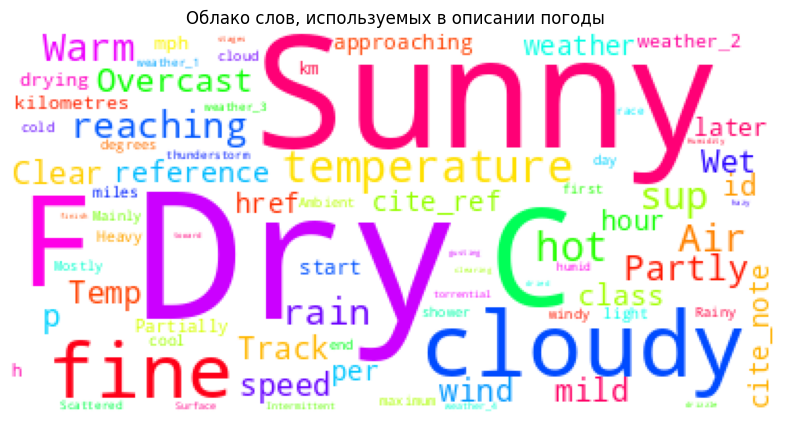

In [65]:
text = ' '.join(i for i in weather_full['weather'].fillna('nan'))
wordcloud = WordCloud(background_color="white", colormap="hsv", collocations=False).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Облако слов, используемых в описании погоды')
plt.show()

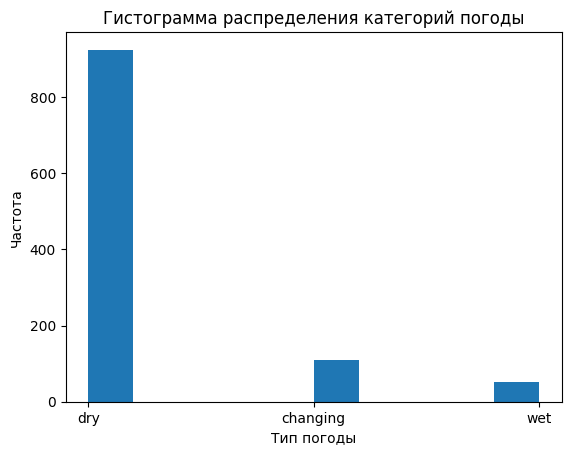

In [66]:
plt.hist(weather_full['weather_main'].fillna('nan'))
plt.title('Гистограмма распределения категорий погоды')
plt.xlabel('Тип погоды')
plt.ylabel('Частота')
plt.show()

Как видно на графиках выше, самая популярная категория погоды - dry, а самая редкая - wet

### Парсинг времени каждого гонщика в квалификациях

Парсинг данной инфорации представлен в файле parsing_qualifying, результаты были сохранены на гитхаб в таблицу quali_full.csv

Добавим все в таблицу working

In [67]:
quali_full = pd.read_csv('https://raw.githubusercontent.com/pavleke/project-formula-1/main/quali_full.csv')

In [68]:
working.set_index(['raceId', 'driverId'], inplace=True)
quali_full.set_index(['raceId', 'driverId'], inplace=True)
quali_full.drop('resultId', axis=1, inplace=True)
working_full = working.merge(quali_full, right_index=True, left_index=True)

In [ ]:
working_full.reset_index(inplace=True)
working_full.drop(['driverTime', 'qBestMill', 'time', 'avLapTimeMill', 'res_q'], axis=1, inplace=True)

In [ ]:
working_full.drop(['Unnamed: 0'], axis=1, inplace=True)

In [ ]:
working_full.head()

,raceId,driverId,index,year,constructorId,resultId,grid,positionOrder,laps,milliseconds,...,circuitId,AvTeamLapTimeMill,debut_raceId,is_debut,avPosTeam,overCir,overYear,raceNewid,driverNumber,driverTimeMill
0,1,1,0,2009,1,7573,18,20,58,\N,...,1,97563.758621,36,False,10.411765,5.135688,3.858824,804,1,86454.0
1,1,2,1,2009,2,7563,9,10,58,5662869,...,1,96398.181661,158,False,11.088235,5.135688,3.858824,804,6,85827.0
2,1,3,2,2009,3,7559,5,6,58,5661506,...,1,94717.203854,53,False,10.970588,5.135688,3.858824,804,16,85846.0
3,1,4,3,2009,4,7558,10,5,58,5660663,...,1,99681.610632,141,False,12.411765,5.135688,3.858824,804,7,86026.0
4,1,5,4,2009,1,7572,12,19,0,\N,...,1,97563.758621,36,False,10.411765,5.135688,3.858824,804,2,86184.0


# Проверка гипотез

## Гипотеза 1

Мы решили пренебречь этой информацией, так как данных по каждому кругу в каждой гонке недостаточно для того, чтобы делать какие-либо показательные выводы

## Гипотезы 2.1 и 2.2

Для проверки этих гипотез сначала нужно получить новые показатели - collision_rate для каждого гонщика и technical_rate для каждой команды

Посчитаем сначала долю гонок для каждого гонщика, которые закончились аварией. Это нужно для того, чтобы оценить насколько стиль вождения каждого гонщика приводит к авариям.

In [ ]:
grouped_col = working_full.groupby(['driverId', 'status_short']).size().unstack(fill_value=0)['collision']
collision_rate = pd.DataFrame(grouped_col/working_full.groupby('driverId').count()['status_short'])
collision_rate.rename(columns={0: 'collision_rate'}, inplace=True)
working_full = working_full.merge(collision_rate, left_on='driverId', right_index=True)

Также посчитаем среднее количество обгонов за гонку для каждого гонщика, для того, чтобы потом посмотреть на корреляцию между этим показателем и collision_rate. Для дальнейшей проверки гипотезы создадим отдельный датафрейм df_for_testing_2_1, в котором находятся два исследуемых признака

In [ ]:
working_full['overtakings'] = working_full['grid'] - working_full['positionOrder']
mean_overtakings = pd.DataFrame(working_full.groupby(['driverId'])['overtakings'].mean())
df_for_testing_2_1 = mean_overtakings.merge(collision_rate, left_index=True, right_index=True)

Посчитаем долю технических сходов для каждой команды. Так как каждый год во время зимней паузы команды дорабатывают свою машину или разрабатывают новую, если регламент был изменен, мы решили, что логичнее считать процент технических сходов для каждой команды ежегодно.

In [ ]:
grouped_tech = working_full.groupby(['constructorId', 'year', 'status_short']).size().unstack(fill_value=0)['technical']
technical_rate = pd.DataFrame(grouped_tech/working_full.groupby(['constructorId', 'year']).count()['status_short'])
technical_rate.rename(columns={0: 'technical_rate'}, inplace=True)
working_full = working_full.merge(technical_rate, left_on=['constructorId', 'year'], right_index=True)

In [ ]:
working_full.head()

,raceId,driverId,index,year,constructorId,resultId,grid,positionOrder,laps,milliseconds,...,is_debut,avPosTeam,overCir,overYear,raceNewid,driverNumber,driverTimeMill,collision_rate,overtakings,technical_rate
0,1,1,0,2009,1,7573,18,20,58,\N,...,False,10.411765,5.135688,3.858824,804,1,86454.0,0.045161,-2,0.058824
20,2,1,20,2009,1,7580,12,7,31,4312825,...,False,10.411765,4.771845,3.858824,805,1,95280.0,0.045161,5,0.058824
40,3,1,40,2009,1,7599,9,6,56,7135351,...,False,10.411765,3.584795,3.858824,806,1,95776.0,0.045161,3,0.058824
60,4,1,60,2009,1,7617,5,4,57,5530278,...,False,10.411765,3.682500,3.858824,807,1,92851.0,0.045161,1,0.058824
80,5,1,80,2009,1,7642,14,9,65,\N,...,False,10.411765,4.773296,3.858824,808,1,80991.0,0.045161,5,0.058824


### Проверка гипотезы 2.1

**$H_0:$** corr(mean_overtakings, collision_rate) $= 0$

**$H_1:$** corr(mean_overtakings, collision_rate) $\neq 0$

In [ ]:
corr = np.corrcoef(df_for_testing_2_1['overtakings'], df_for_testing_2_1['collision_rate'])[0][1]
corr

0.06227284104312352

In [ ]:
t_obs = corr*np.sqrt(len(df_for_testing_2_1['overtakings']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(df_for_testing_2_1['overtakings'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между обгонностью и collision_rate отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0, то есть корреляция не является значимой')

Наблюдаемое t = 1.822287554352381
Реальное t на уровне значимости 0.05 = 1.6466419451812693
Гипотеза об отсутствии корреляции между обгонностью и collision_rate отвергается в пользу альтернативной на уровне значимости 0.05


Заметим, что корреляция между данными признаками достаточно мала, но все же положительна, то есть между средним количеством обгонов для каждого гонщика и его процентом аварий существует положительная зависимость. Возможно, корреляция достаточно мала из-за того, что количество обгонов, совершенное гонщиком нейтрализуется его проигрышами позиций из-за аварий.

**Проверим гипотезу о корреляции между процентом аварий гонщика и изменением его позиций по модулю (вместо признака overtakings будем изучать признак abs_overtakings).**

Эта гипотеза не такая интересная с точки зрения того, положительно ли влияет агрессивный стиль вождения гонщика на его пощиции на финише, однако она интересная с точки зрения того, действительно ли количество аварий, в которых участвует гонщик и количество борьбы, в которой он участвует, имеет положительную зависимость.

In [ ]:
working_full['abs_overtakings'] = abs(working_full['grid'] - working_full['positionOrder'])
mean_overtakings = pd.DataFrame(working_full.groupby(['driverId'])['abs_overtakings'].mean())
df_for_testing_2_2 = mean_overtakings.merge(collision_rate, left_index=True, right_index=True)

In [ ]:
corr_abs = np.corrcoef(df_for_testing_2_2['abs_overtakings'], df_for_testing_2_2['collision_rate'])[0][1]
corr_abs

-0.15921210652618312

Проверим теперь значимость этой корреляции

In [ ]:
t_obs = corr_abs*np.sqrt(len(df_for_testing_2_2['abs_overtakings']) - 2)/(np.sqrt(1 - corr_abs**2))
t_real = sts.t.ppf(0.95, len(df_for_testing_2_2['abs_overtakings'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между  между обгонностью и collision_rate отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0, то есть корреляция не является значимой')

Наблюдаемое t = -4.710054422137039
Реальное t на уровне значимости 0.05 = 1.6466419451812693
Гипотеза об отсутствии корреляции между  между обгонностью и collision_rate отвергается в пользу альтернативной на уровне значимости 0.05


Посмотрев на полученные результаты, мы подумали, что, возможно, корреляция получается отрицательной из-за того, что гонщики, которые больше рискуют, делают это для того, чтобы предотвратить большую потерю позиций, то есть агрессивно защищаются от соперников, пытающихся их обогнать, что повышает риск аварии. Поэтому мы решили еще проверить корреляцию между риском аварии гонщика и признаком, который мы добавили в столбец 'overtakings_only_positive', в котором мы учитываем только отыгранные позиции относительно стартовой, а все проигранные считаем равными нулю

In [ ]:
working_full['overtakings_only_positive'] = working_full['overtakings']
working_full.loc[working_full['overtakings'] < 0, 'overtakings_only_positive'] = 0

In [ ]:
working_full.head()

,raceId,driverId,index,year,constructorId,resultId,grid,positionOrder,laps,milliseconds,...,overCir,overYear,raceNewid,driverNumber,driverTimeMill,collision_rate,overtakings,technical_rate,abs_overtakings,overtakings_only_positive
0,1,1,0,2009,1,7573,18,20,58,\N,...,5.135688,3.858824,804,1,86454.0,0.045161,-2,0.058824,2,0
20,2,1,20,2009,1,7580,12,7,31,4312825,...,4.771845,3.858824,805,1,95280.0,0.045161,5,0.058824,5,5
40,3,1,40,2009,1,7599,9,6,56,7135351,...,3.584795,3.858824,806,1,95776.0,0.045161,3,0.058824,3,3
60,4,1,60,2009,1,7617,5,4,57,5530278,...,3.682500,3.858824,807,1,92851.0,0.045161,1,0.058824,1,1
80,5,1,80,2009,1,7642,14,9,65,\N,...,4.773296,3.858824,808,1,80991.0,0.045161,5,0.058824,5,5


In [ ]:
mean_overtakings_pos = pd.DataFrame(working_full.groupby(['driverId'])['overtakings_only_positive'].mean())
df_for_testing_2_3 = mean_overtakings_pos.merge(collision_rate, left_index=True, right_index=True)

In [ ]:
corr_pos = np.corrcoef(df_for_testing_2_3['overtakings_only_positive'], df_for_testing_2_3['collision_rate'])[0][1]
corr_pos

-0.0903768479656233

In [ ]:
t_obs = corr_pos*np.sqrt(len(df_for_testing_2_2['abs_overtakings']) - 2)/(np.sqrt(1 - corr_pos**2))
t_real = sts.t.ppf(0.95, len(df_for_testing_2_2['abs_overtakings'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между  между обгонностью и collision_rate отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0, то есть корреляция не является значимой')

Наблюдаемое t = -2.650407443503022
Реальное t на уровне значимости 0.05 = 1.6466419451812693
Гипотеза об отсутствии корреляции между  между обгонностью и collision_rate отвергается в пользу альтернативной на уровне значимости 0.05


Как мы видим, полученная корреляция также является значимой, но отрицательной. Получив достаточно противоречивые результаты, мы решили построить несколько графиков: гистограммы распределения полученных значений изменений позиций, а также гистограммы рассеяния между collision_rate и различными оценками среднего количества изменений позиций средни гонщиков

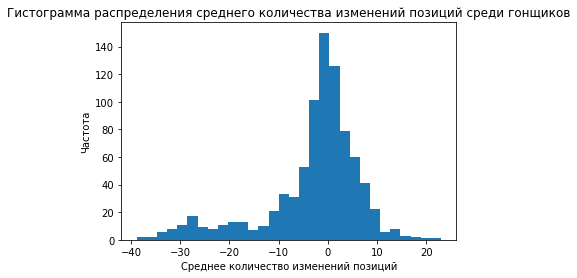

In [ ]:
plt.hist(df_for_testing_2_1['overtakings'], bins=30)
plt.title('Гистограмма распределения среднего количества изменений позиций среди гонщиков')
plt.xlabel('Среднее количество изменений позиций')
plt.ylabel('Частота')
plt.show()

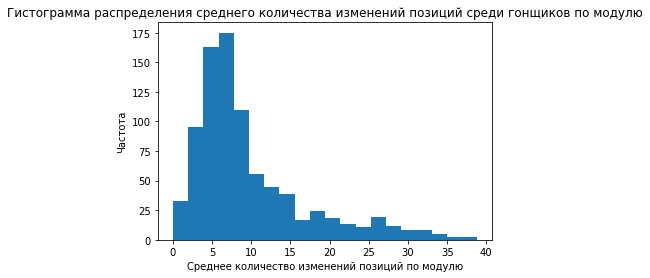

In [ ]:
plt.hist(df_for_testing_2_2['abs_overtakings'], bins=20)
plt.title('Гистограмма распределения среднего количества изменений позиций среди гонщиков по модулю')
plt.xlabel('Среднее количество изменений позиций по модулю')
plt.ylabel('Частота')
plt.show()

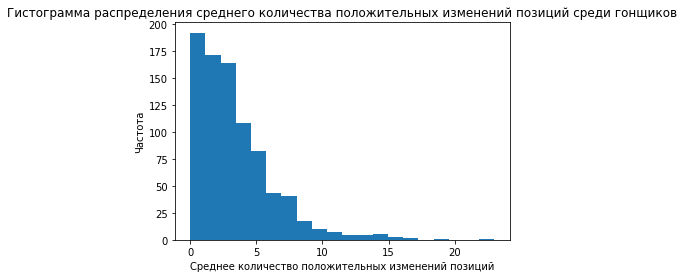

In [ ]:
plt.hist(df_for_testing_2_3['overtakings_only_positive'], bins=20)
plt.title('Гистограмма распределения среднего количества положительных изменений позиций среди гонщиков')
plt.xlabel('Среднее количество положительных изменений позиций')
plt.ylabel('Частота')
plt.show()

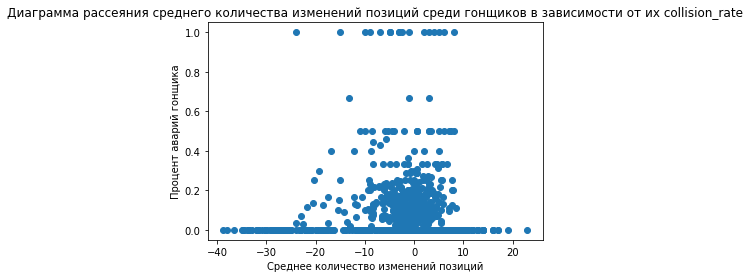

In [ ]:
plt.scatter(df_for_testing_2_1['overtakings'], df_for_testing_2_1['collision_rate'])
plt.title('Диаграмма рассеяния среднего количества изменений позиций среди гонщиков в зависимости от их collision_rate')
plt.xlabel('Среднее количество изменений позиций')
plt.ylabel('Процент аварий гонщика')
plt.show()

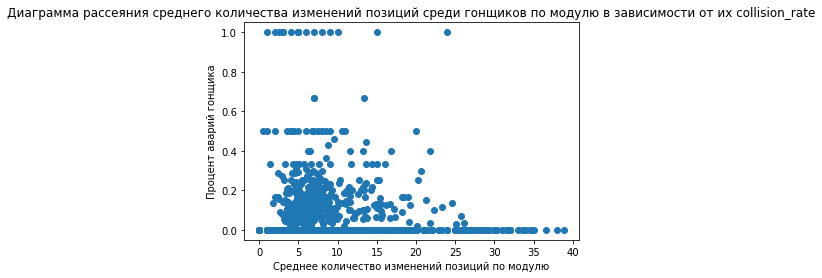

In [ ]:
plt.scatter(df_for_testing_2_2['abs_overtakings'], df_for_testing_2_2['collision_rate'])
plt.title('Диаграмма рассеяния среднего количества изменений позиций среди гонщиков по модулю в зависимости от их collision_rate')
plt.xlabel('Среднее количество изменений позиций по модулю')
plt.ylabel('Процент аварий гонщика')
plt.show()

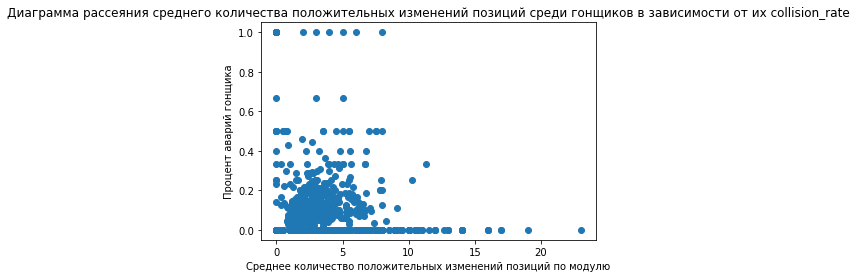

In [ ]:
plt.scatter(df_for_testing_2_3['overtakings_only_positive'], df_for_testing_2_3['collision_rate'])
plt.title('Диаграмма рассеяния среднего количества положительных изменений позиций среди гонщиков в зависимости от их collision_rate')
plt.xlabel('Среднее количество положительных изменений позиций по модулю')
plt.ylabel('Процент аварий гонщика')
plt.show()

## Проверка гипотезы 2.2

In [ ]:
mean_overtakings = pd.DataFrame(working_full.groupby(['constructorId', 'year'])['overtakings'].mean())
df_test_2 = mean_overtakings.merge(technical_rate, left_index=True, right_index=True)

**$H_0:$** corr(mean_overtakings, technical_rate) $= 0$

**$H_1:$** corr(mean_overtakings, technical_rate) $\neq 0$

In [ ]:
corr = np.corrcoef(df_test_2['overtakings'], df_test_2['technical_rate'])[0][1]
corr

0.07648743561703042

In [ ]:
t_obs = corr*np.sqrt(len(df_test_2['overtakings']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(df_test_2['overtakings'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между обгонностью и technical_rate отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0, то есть корреляция не является значимой')

Наблюдаемое t = 2.5315012938676995
Реальное t на уровне значимости 0.05 = 1.6462540623158182
Гипотеза об отсутствии корреляции между обгонностью и technical_rate отвергается в пользу альтернативной на уровне значимости 0.05


Таким образом, между обгонностью каждой команды и процентом ее технических сходов каждый год наблюдается положительная корреляция, которую можно считать значимой на уровне значимости 0.05.

Мы подумали, что это может так происходить так, потому что команды, которые редко сходят по техническим причинам, могут часто стартовать впереди, поэтому редко кого-то обгонять в гонке, в то время как у команд, которые чаще сходят, больше шансов выполнить обгон, так как они стартуют ниже на стартовой решетке

Аналогично прошлой гипотезе, мы решили посмотреть на корреляцию между процентом технических сходов команды каждый год и среднем количеством борьбы для этой команды (другими словами, мы смотрим на все изменения итоговых позиций относительно стартовой, независимо от того, выиграл пилот это количество позиций или проиграл)

**Проверим гипотезу о корреляции между процентом технических сходов команды и среднем изменением ее позиций по модулю (вместо признака overtakings будем изучать признак abs_overtakings).**

In [ ]:
mean_overtakings = pd.DataFrame(working_full.groupby(['constructorId', 'year'])['abs_overtakings'].mean())
df_test_2_2 = mean_overtakings.merge(technical_rate, left_index=True, right_index=True)

In [ ]:
corr = np.corrcoef(df_test_2_2['abs_overtakings'], df_test_2_2['technical_rate'])[0][1]
corr

-0.15243627460095915

Как мы видим, этот результат похож на аналогичный результат для гонщика и его collision_rate

## Гипотеза 3

Данная гипотеза была изменена в процессе нашей работы, так как мы поняли, что данных по каждому кругу в каждой гонке недостаточно, поэтому и данных для среднего времени круга для каждой команды недостаточно. Кроме того, оценивать среднее время круга в гонке неразумно, если мы собираемся предсказывать результаты гонки по итогам квалификации. Поэтому мы решили, что можно измерять среднюю скорость команды на основе средней скорости команды в квалификации. Это позволит понять, когда у кого-либо в квалификации произошел форс-мажор, поэтому в гонке он сможет существенно улучшить свое место. Так, например, может случиться такое, что гонщик на потенциально быстрейшей машине врезался в квалификации или, например, у него сломалась машина или произошло что-то странное и поэтому он не прошел во второй или третий сегмент квалификации. Однако в гонке он может быть настолько быстр, что быстро обгонит всех остальных пилотов.

Создадим столбец avTeamQualiMill на основе столбца driverTimeMill со временем круга в квалификации

In [ ]:
working_full.set_index(['raceId', 'constructorId'], inplace=True)

In [ ]:
working_full['avTeamQualiMill'] = pd.DataFrame(working_full.groupby(['raceId', 'constructorId'])['driverTimeMill'].mean())

In [ ]:
working_full.reset_index(inplace=True)

In [ ]:
working_full.head()

,raceId,constructorId,driverId,index,year,resultId,grid,positionOrder,laps,milliseconds,...,overYear,raceNewid,driverNumber,driverTimeMill,collision_rate,overtakings,technical_rate,abs_overtakings,overtakings_only_positive,avTeamQualiMill
0,1,1,1,0,2009,7573,18,20,58,\N,...,3.858824,804,1,86454.0,0.045161,-2,0.058824,2,0,86319.0
1,2,1,1,20,2009,7580,12,7,31,4312825,...,3.858824,805,1,95280.0,0.045161,5,0.058824,5,5,95151.5
2,3,1,1,40,2009,7599,9,6,56,7135351,...,3.858824,806,1,95776.0,0.045161,3,0.058824,3,3,96211.0
3,4,1,1,60,2009,7617,5,4,57,5530278,...,3.858824,807,1,92851.0,0.045161,1,0.058824,1,1,93165.0
4,5,1,1,80,2009,7642,14,9,65,\N,...,3.858824,808,1,80991.0,0.045161,5,0.058824,5,5,81333.0


### Проверка гипотезы 3

Сформулируем гипотезу:

$Н_0$: корреляция между разницей между временами напарников по команде и разницей их итоговых позиций на финише равна 0

$Н_1$: корреляция не равна нулю

Для этого найдем среднюю позиции каждой команды в каждой гонке (не путать это со столбцом avPosTeam, в котором мы посчитали среднюю позицию каждой команды в каждом сезоне) и найдем разницу между этим и результатом гонщика.

In [ ]:
working_full.set_index(['raceId', 'constructorId'], inplace=True)
working_full['avPosTeamRace'] = pd.DataFrame(working_full.groupby(['raceId', 'constructorId'])['positionOrder'].mean())

In [ ]:
working_full.reset_index(inplace=True)

In [ ]:
working_full['diffPosOrder'] = working_full['avPosTeamRace'] - working_full['positionOrder']

In [ ]:
working_full['driverTimeMill'].replace(0, np.nan, inplace=True)

Посчитаем разницу между временем гонщика в квалификации и средним временем команды в квалификации, это будет в столбике diffQualiMill

In [ ]:
working_full['diffQualiMill'] = (working_full['avTeamQualiMill'] - working_full['driverTimeMill'])/working_full['driverTimeMill']

In [ ]:
working_full['diffQualiMill'].fillna(0, inplace=True)

In [ ]:
working_full['diffPosOrder'].fillna(0, inplace=True)

In [ ]:
working_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26097 entries, 0 to 26096
Data columns (total 33 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   raceId                     26097 non-null  int64  
 1   constructorId              26097 non-null  int64  
 2   driverId                   26097 non-null  int64  
 3   index                      26097 non-null  int64  
 4   year                       26097 non-null  int64  
 5   resultId                   26097 non-null  int64  
 6   grid                       26097 non-null  int64  
 7   positionOrder              26097 non-null  int64  
 8   laps                       26097 non-null  int64  
 9   milliseconds               26097 non-null  object 
 10  fastestLapTime             26097 non-null  object 
 11  status                     26097 non-null  object 
 12  status_short               26097 non-null  object 
 13  weather_main               23410 non-null  obj

Посчитаем корреляцию между этими двумя величинами (diffPosOrder и diffQualiMill)

In [ ]:
corr = sts.pearsonr(working_full['diffPosOrder'], working_full['diffQualiMill'])[0]

In [ ]:
corr

-0.01822063755690585

Теперь проверим значимости коэффициента корреляции с помощью t-теста. Заметим, что из-за большого размера выборки можно сказать, что распределение стремится к нормальному. В данном случае H0 заключается в отсутствии корреляции между переменными ($corr = 0$), соответственно альтернативная гипотеза заключается в том, что $corr \neq 0$

In [ ]:
t_obs = corr*np.sqrt(len(working_full['diffQualiMill']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(working_full['diffQualiMill'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0')

Наблюдаемое t = -2.943840819082647
Реальное t на уровне значимости 0.05 = 1.644912022183254
Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05


**Вывод**: мы посчитали корреляцию и осознали, что, на самом деле, нам нельзя судить о значимости корреляции между оцениваемыми переменными, так как одна из них является ранговой, а вторая нет. Поэтому, несмотря на то, что мы видим, что существует некоторая отрицательная зависимость между временем квалификации и результатом гонки, лучше посчитать корреляцию между стартовой позицией (grid) и итоговым результатом (positionOrder), так как обе эти переменные являются ранговыми. В одном из следующих разделов мы посчитаем эту корреляцию

## Гипотеза 4

Cкорость гонщика в квалификации влияет на его шансы на победу

### Проверка гипотезы 4

In [ ]:
working_full['driverTimeMill'].fillna(0, inplace=True)

In [ ]:
grouped_quali_time = pd.DataFrame(working_full.groupby('raceId').mean()['driverTimeMill'])
grouped_quali_time.rename(columns={'driverTimeMill': 'avTimeByQuali'}, inplace=True)

In [ ]:
working_full = working_full.merge(grouped_quali_time, left_on='raceId', right_index=True)

In [ ]:
working_full['driverTimeMillNormed'] = working_full['driverTimeMill']/working_full['avTimeByQuali']

In [ ]:
working_full['driverTimeMillNormed'].fillna(0, inplace=True)

In [ ]:
working_full.head()

,raceId,constructorId,driverId,index,year,resultId,grid,positionOrder,laps,milliseconds,...,overtakings,technical_rate,abs_overtakings,overtakings_only_positive,avTeamQualiMill,avPosTeamRace,diffPosOrder,diffQualiMill,avTimeByQuali,driverTimeMillNormed
0,1,1,1,0,2009,7573,18,20,58,\N,...,-2,0.058824,2,0,86319.0,19.5,-0.5,-0.001562,86041.75,1.004791
17,1,1,5,4,2009,7572,12,19,0,\N,...,-7,0.058824,7,0,86319.0,19.5,0.5,0.001566,86041.75,1.001653
622,1,2,2,1,2009,7563,9,10,58,5662869,...,-1,0.117647,1,0,85874.5,12.0,2.0,0.000553,86041.75,0.997504
639,1,2,9,8,2009,7567,4,14,55,\N,...,-10,0.117647,10,0,85874.5,12.0,-2.0,-0.000553,86041.75,0.998608
1045,1,3,3,2,2009,7559,5,6,58,5661506,...,-1,0.088235,1,0,85960.0,12.0,6.0,0.001328,86041.75,0.997725


Посчитаем корреляцию между итоговым результатом гонки (позицией каждого гонщика на финише) и его временем в квалификации

In [ ]:
corr = np.corrcoef(working_full['positionOrder'], working_full['driverTimeMillNormed'])[0][1]

In [ ]:
corr

-0.07956939739324317

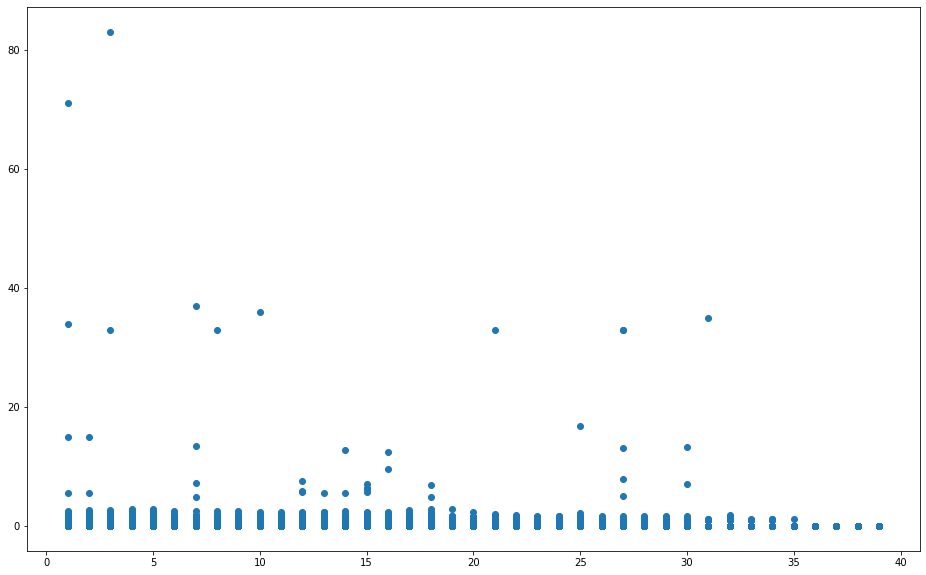

In [ ]:
plt.figure(figsize=(16,10))
plt.scatter(working_full['positionOrder'], working_full['driverTimeMillNormed'])

Теперь проверим значимости коэффициента корреляции с помощью t-теста. Заметим, что из-за большого размера выборки можно сказать, что распределение стремится к нормальному. В данном случае H0 заключается в отсутствии корреляции между переменными ($corr=0$), соответственно альтернативная гипотеза заключается в том, что $corr \neq 0$

In [ ]:
t_obs = corr*np.sqrt(len(working_full['driverTimeMill']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(working_full['driverTimeMill'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0')

Наблюдаемое t = -12.894482354792508
Реальное t на уровне значимости 0.05 = 1.644912022183254
Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05


Аналогично прошлому пункту, несмотря на то, что корреляцию, согласно тесту, можно считать значимой, на самом деле, из-за того, что одна из переменных является ранговой, а вторая нет, оценивать данную корреляцию не очень корректно

## Проверка гипотезы про связь grid и positionOrder

In [ ]:
corr = np.corrcoef(working_full['positionOrder'], working_full['grid'])[0][1]
corr

0.15193839429237882

In [ ]:
t_obs = corr*np.sqrt(len(working_full['grid']) - 2)/(np.sqrt(1 - corr**2))
t_real = sts.t.ppf(0.95, len(working_full['grid'])-2)
print('Наблюдаемое t = ' + str(t_obs))
print('Реальное t на уровне значимости 0.05 = ' + str(t_real))
if (t_obs < -t_real) or (t_obs > t_real):
    print('Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05')
else:
    print('Нет оснований для отвержения гипотезы H0')

Наблюдаемое t = 24.832351971224238
Реальное t на уровне значимости 0.05 = 1.644912022183254
Гипотеза об отсутствии корреляции между итоговым результатом гонки и временем в квалификации отвергается в пользу альтернативной на уровне значимости 0.05


## Проверка гипотезы 5

Для проверки гипотезы возьмем не только дебютные, но и первые 10 гонок для пилотов (учитывая, что гонщик не сразу после первой гонки становится более-менее опытным). 10 гонок - примерно половина одного сезона - как раз то время перед большим летним перерывом, за которое новый гонщик может ассимилироваться.

In [ ]:
all_newbie = np.where((cir_q_av_st_w_r['raceId'] < (cir_q_av_st_w_r['debut_raceId'] + 10)) & (cir_q_av_st_w_r['raceId'] >= cir_q_av_st_w_r['debut_raceId']))[0]
df_all_newbie = cir_q_av_st_w_r.loc[all_newbie][['raceId', 'driverId', 'status', 'status_short', 'debut_raceId', 'is_debut']]

In [ ]:
all_exp = np.where((cir_q_av_st_w_r['raceId'] >= (cir_q_av_st_w_r['debut_raceId'] + 10)) | (cir_q_av_st_w_r['raceId'] < cir_q_av_st_w_r['debut_raceId']))[0]
df_all_exp = cir_q_av_st_w_r.loc[all_exp][['raceId', 'driverId', 'status', 'status_short', 'debut_raceId', 'is_debut']]

Сформулируем гипотезы об отношении вероятностей попасть в аварию неопытных гонщиков к опытным гонщикам:

$Н_0: RR = 1$

$H_1: RR > 1$

Построим 95% асимптотический интервал для отношения вероятностей (RR - Risk Ratio).

Для оценки RR построим таблицу сопряжённости, поделив гонщиков на 4 группы в зависимости от двух признаков:

1) "новичок" ли гонщик или нет (первые ли 4 гонки или последующие)

2) статус гонки ("collision" или другой).

Стоит отметить, что для оценки мы используем только статус 'collision', так как при описании гипотезы 2 мы попытались добавить в эту категорию только те причины сходов гонщика, которые произошли из-за действий самих гонщиков, а не сотрудников команды или каких-либо внешних факторов.

In [ ]:
status_newbie = np.unique(df_all_newbie['status_short'], return_counts=True)
status_exp = np.unique(df_all_exp['status_short'], return_counts=True)

In [ ]:
d_c = status_newbie[1][np.where(status_newbie[0] == 'collision')][0]
d_nc = status_newbie[1].sum() - d_c

nd_c = status_exp[1][np.where(status_exp[0] == 'collision')][0]
nd_nc = status_exp[1].sum() - nd_c

contingency_table = pd.DataFrame({'if_debut': ['debut', 'not_debut'], 'collision': [d_c, nd_c], 'not_collision': [d_nc, nd_nc]})
contingency_table = contingency_table.set_index('if_debut')
contingency_table #таблица сопряженности

,collision,not_collision
if_debut,,
debut,338,2642
not_debut,2415,20445


In [ ]:
risk_newbie = contingency_table['collision'].loc['debut'] / status_newbie[1].sum()
risk_exp = contingency_table['collision'].loc['not_debut'] / status_exp[1].sum()

RR_est = risk_newbie / risk_exp
RR_est #оценка Risk Ratio

1.0736420859560631

In [ ]:
#стандартная ошибка логарифма RR
se_log_RR = ((1/196) - (1/status_newbie[1].sum()) + (1/2557) - (1/status_exp[1].sum())) ** (1/2)

alpha = 0.05

z_crit = sts.norm.ppf(1 - alpha)

left = np.exp(np.log(RR_est) - z_crit * se_log_RR)
right = np.exp(np.log(RR_est) + z_crit * se_log_RR)
print(f'95% асимптотический интервал: [', left, ',', right, ']')

95% асимптотический интервал: [ 0.9544993857032682 , 1.2076564385494917 ]


Проверим гипотезу. Для этого посчитаем наблюдаемое значение статистики (z_obs) и сравним с критическим (z_crit).

In [ ]:
z_obs = np.log(RR_est) / se_log_RR

pvalue = (1 - sts.norm.cdf(RR_est))

print('Значение p-value равно ', pvalue)

if z_obs > z_crit:
    print('Н0 отвергается в пользу Н1 при уровне значимости 0.05')
else:
    print('Н0 не отвергается при уровне значимости 0.05.')

Значение p-value равно  0.14149156363495974
Н0 не отвергается при уровне значимости 0.05.


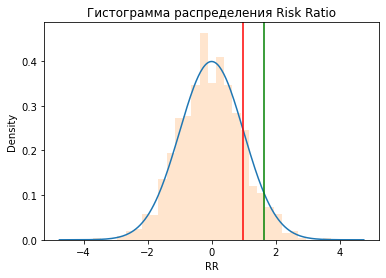

In [ ]:
x = np.linspace(sts.norm.ppf(0.000001), sts.norm.ppf(0.999999), 275)
plt.plot(x, sts.norm.pdf(x))
plt.hist(sts.norm.rvs(size=1000), density=True, bins='auto', histtype='stepfilled', alpha=0.2)
plt.axvline(x = z_crit, color='g')
plt.axvline(x = z_obs, color='r')
plt.title('Гистограмма распределения Risk Ratio')
plt.xlabel('RR')
plt.ylabel('Density');

Так как гипотеза не отвергается, то можно сделать вывод, что неопытные и опытные гонщики имеют равные шансы попасть в аварию, и на итоговый результат гонки это не влияет.

У нас есть два объяснения этому (довольно неочевидному) факту:

1) Молодые и неопытные гонщики не пытаются в первых же гонках проявить себя и сильно рисковать. Поэтому и вероятность попасть в аварию из-за собственной ошибки примерно такая же, как и у других гонщиков.

2) Если новичок все же ошибся и врезался в другого, то последний тоже не сможет продолжить гонку из-за повреждений, а его статус изменится на 'collision'. Следовательно, риски пилотов сравниваются.

## Проверка гипотезы 8

Многие люди (не фанаты Формулы 1) считают, что смотреть на то, как гонщики катаются 70 раз по одинаковому кругу каждую неделю, довольно скучно. Мы конечно же с ними не согласны, потому что круги эти - разные!

Но прежде, чем высказывать абсолютное несогласие, проверим гипотезу об обгонности каждой трассы.

Для того, чтобы определить гипотетическую дисперсию генеральной совокупности, посмотрим, какая обгонность действительно является высокой.

На официальном новостном портале f1news.ru есть информация о том, что в 2022 году обгонов стало намного больше (по сравнению с предыдущими сезонами). Так как в среднем совершается 36.25 обгонов за гонку, то у одного гонщика изменение позиции составляет в среднем 1.8. Если округлить до двух и возвести в квадрат - то получится, что дисперсия равна 4. Этим значением мы и поспользуемся.

(ссылка на статью с разбором обгонов:
https://www.f1news.ru/news/f1-162432.html#:~:text=%D0%98%20%D0%BF%D0%BE%D0%BB%D1%83%D1%87%D0%B0%D0%B5%D1%82%D1%81%D1%8F%2C%20%D1%87%D1%82%D0%BE%20%D0%B7%D0%B0%2012,29%2C41%20%D0%B7%D0%B0%20%D0%93%D1%80%D0%B0%D0%BD%20%D0%9F%D1%80%D0%B8 )

**Гипотеза:** все трассы сильно различаются по обгонности - дисперсия обгонности трасс высокая.

Н0: $Var($overCir$) > 4$.

H1: $Var($overCir$) < 4$.

В части с описанием гипотез и подготовкой признаков для их последующей проверки мы создали признак overtaking. Сейчас таблица со средней обгонностью по трассам называется over_. Построим диаграмму распределения обгонности в зависимости от ID трассы

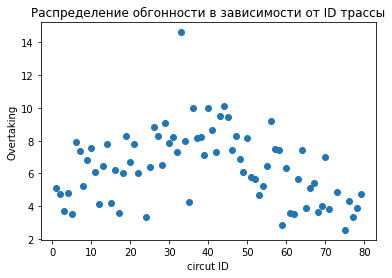

In [ ]:
plt.scatter(over_.index, over_);
plt.title('Распределение обгонности в зависимости от ID трассы')
plt.xlabel('circut ID')
plt.ylabel('Overtaking');

В выборке есть выброс. Удалим его перед проверкой гипотезы.

In [ ]:
over_ = over_.drop([(np.where(over_.overtaking == over_.overtaking.max())[0] + 2)[0]])

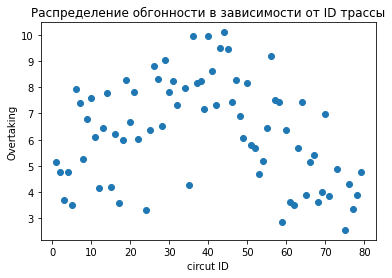

In [ ]:
plt.scatter(over_.index, over_);
plt.title('Распределение обгонности в зависимости от ID трассы')
plt.xlabel('circut ID')
plt.ylabel('Overtaking');

In [ ]:
var_overtaking = (over_['overtaking'].std()) ** 2 #оценка дисперсии выборочной

In [ ]:
#значение статистики хи-квадрат:
chi_test = ((over_['overtaking'].shape[0] - 1) * var_overtaking) / 4

In [ ]:
chi_crit = sts.chi2.ppf(0.05, over_['overtaking'].shape[0])

In [ ]:
print(f'Тестовая статистика: ', chi_test, ', критическая статистика: ', chi_crit)
if chi_test > chi_crit:
    print('Нет оснований отвергать гипотезу Н0.')
else:
    print('Гипотеза Н0 отвергается в пользу Н1.')

Тестовая статистика:  71.66891739950559 , критическая статистика:  56.05407229136661
Нет оснований отвергать гипотезу Н0.


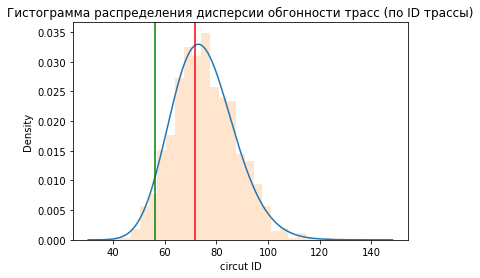

In [ ]:
x = np.linspace(sts.chi2.ppf(0.000001, 75), sts.chi2.ppf(0.999999, 75), 275)
plt.plot(x, sts.chi2.pdf(x, 75))
plt.hist(sts.chi2.rvs(75, size=1000), density=True, bins='auto', histtype='stepfilled', alpha=0.2)
plt.axvline(x = chi_crit, color='g')
plt.axvline(x = chi_test, color='r')
plt.title('Гистограмма распределения дисперсии обгонности трасс (по ID трассы)')
plt.xlabel('circut ID')
plt.ylabel('Density');

Нулевая гипотеза не отвергается, следовательно, все трассы сильно различаются по обгонности.

## Проверка гипотезы 9

### В различные сезоны в среднем разное количество обгонов

Аналогично, как и в гипотезе №8, гипотетическую дисперсию возьмем равной 4.

$Н_0$: $Var($year_over$) > 4$.

$H_1$: $Var($year_over$) < 4$.

Из раздела, в котором мы описывали гипотезу 9 и подготавливали данные для ее дальнейшей проверки, нам известно, что данные о средней обгонности в каждый сезон находится в таблице year_over_

Посмотрим на диаграмму рассеяния средней обгонности в каждый из сезонов и исследуем данные на предмет выбросов

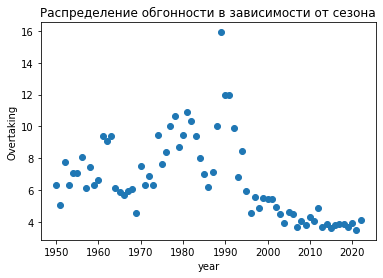

In [ ]:
plt.scatter(year_over_.index, year_over_);
plt.title('Распределение обгонности в зависимости от сезона')
plt.xlabel('year')
plt.ylabel('Overtaking');

Удалим выброс

In [ ]:
year_over_ = year_over_.reset_index()
year_over_ = year_over_.drop([(np.where(year_over_.overtaking == year_over_.overtaking.max())[0])[0]])
year_over_ = year_over_.set_index('year')

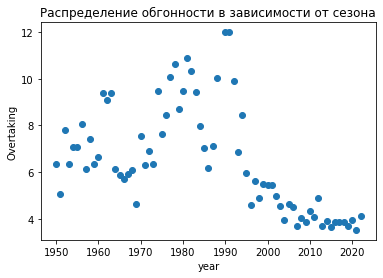

In [ ]:
plt.scatter(year_over_.index, year_over_);
plt.title('Распределение обгонности в зависимости от сезона')
plt.xlabel('year')
plt.ylabel('Overtaking');

Теперь перейдем к проверке гипотезы

In [ ]:
var_year_overtaking = (year_over_['overtaking'].std()) ** 2 #оценка дисперсии выборочной

In [ ]:
#значение статистики хи-квадрат:
chi_test = ((year_over_['overtaking'].shape[0] - 1) * var_year_overtaking) / 4

In [ ]:
chi_crit = sts.chi2.ppf(0.05, year_over_['overtaking'].shape[0] - 1)

In [ ]:
print(f'Тестовая статистика: ', chi_test, ', критическая статистика: ', chi_crit)
if chi_test > chi_crit:
    print('Нет оснований отвергать гипотезу Н0.')
else:
    print('Гипотеза Н0 отвергается в пользу Н1.')

Тестовая статистика:  91.39009179366015 , критическая статистика:  52.60031495044724
Нет оснований отвергать гипотезу Н0.


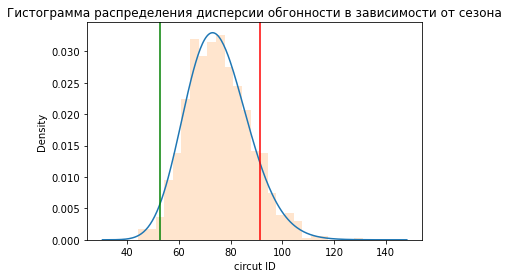

In [ ]:
x = np.linspace(sts.chi2.ppf(0.000001, 75), sts.chi2.ppf(0.999999, 75), 275)
plt.plot(x, sts.chi2.pdf(x, 75))
plt.hist(sts.chi2.rvs(75, size=1000), density=True, bins='auto', histtype='stepfilled', alpha=0.2)
plt.axvline(x = chi_crit, color='g')
plt.axvline(x = chi_test, color='r')
plt.title('Гистограмма распределения дисперсии обгонности в зависимости от сезона')
plt.xlabel('circut ID')
plt.ylabel('Density');

Нулевая гипотеза не отвергается, следовательно, в среднем в некоторые сезоны обгонять сложнее, чем в другие.

## Проверка гипотезы 10

Разделим нашу таблицу working_full на три по типам погоды (которая находится в колонке weather_main)

In [ ]:
df_changing = working_full.loc[working_full['weather_main'] == 'changing']
df_wet = working_full.loc[working_full['weather_main'] == 'wet']
df_dry = working_full.loc[working_full['weather_main'] == 'dry']

## Проверка гипотез 10.1.1 и 10.1.2

### 10.1.1

$H_0: \mu_{wet} = \mu_{dry}$

$H_1: \mu_{wet} > \mu_{dry}$

Где $\mu$ - это мат ожидание количества обгонов в течение гонки. Посчитаем его на основе столбца 'abs_overtakings', сгруппированного по гонкам, так как если считать не на модуль количества обгонов, а на реальное значение, мат ожидание будет около нуля

In [ ]:
wet = pd.DataFrame(df_wet.groupby('raceId')['abs_overtakings'].sum() / df_wet.groupby('raceId')['driverId'].count())
dry = pd.DataFrame(df_dry.groupby('raceId')['abs_overtakings'].sum() / df_dry.groupby('raceId')['driverId'].count())
wet.rename(columns={0: 'over_mean'}, inplace=True)
dry.rename(columns={0: 'over_mean'}, inplace=True)

In [ ]:
#Проверим гипотезу о равенстве дисперсий выборок
d_wet = statistics.variance(wet['over_mean'])
n_wet = len(wet)
d_dry = statistics.variance(dry['over_mean'])
n_dry = len(dry)
F_obs = (d_wet*n_wet/(n_wet-1))/(d_dry*n_dry/(n_dry-1))
F_real = sts.f.ppf(0.95, n_wet-1, n_dry-1)
print(d_wet*n_wet/(n_wet-1), d_dry*n_dry/(n_dry-1))
print(F_obs, F_real)
if F_obs < F_real:
    print('Нет оснований для опровержения гипотезы о равенстве дисперсий')
else:
    print('Дисперсии не равны')

11.07491525202424 9.298214292105506
1.1910798035088537 1.3698468481331534
Нет оснований для опровержения гипотезы о равенстве дисперсий


Теперь можно проверить нашу гипотезу о равенстве математических ожиданий выборок с помощью t-статистики на уровне значимости $\alpha = 0.05$

In [ ]:
d_0 = (d_wet*(n_wet - 1) + d_dry*(n_dry-1))/(n_wet + n_dry -2)
wet_mean = statistics.mean(wet['over_mean'])
dry_mean = statistics.mean(dry['over_mean'])
t_obs = (wet_mean - dry_mean)/np.sqrt(d_0 * (1/n_wet + 1/n_dry))
t_real = sts.t.ppf(0.95, n_wet + n_dry-2)
if t_obs < t_real:
    print('нет оснований отвергать нулевую гипотезу')
else:
    print('Нулевая гипотеза о равенстве математических ожиданий отвергается в пользу гипотезы Н1')

Нулевая гипотеза о равенстве математических ожиданий отвергается в пользу гипотезы Н1


### 10.1.2

Проверим гипотезу, аналогичную 10.1.1, но для математических ожиданий выборок гонок, в которых была дождливая и меняющаяся погода

$H_0: \mu_{changing} = \mu_{wet}$

$H_1: \mu_{changing} > \mu_{wet}$


In [ ]:
changing = pd.DataFrame(df_changing.groupby('raceId')['abs_overtakings'].sum() / df_changing.groupby('raceId')['driverId'].count())
changing.rename(columns={0: 'over_mean'}, inplace=True)

In [ ]:
#Проверим гипотезу о равенстве дисперсий выборок
d_wet = statistics.variance(wet['over_mean'])
n_wet = len(wet)
d_changing = statistics.variance(changing['over_mean'])
n_changing = len(changing)
F_obs = (d_changing*n_changing/(n_changing-1))/(d_wet*n_wet/(n_wet-1))
F_real = sts.f.ppf(0.95, n_changing-1, n_wet-1)
print(d_changing*n_changing/(n_changing-1), d_wet*n_wet/(n_wet-1))
print(F_obs, F_real)
if F_obs < F_real:
    print('Нет оснований для опровержения гипотезы о равенстве дисперсий')
else:
    print('Дисперсии не равны')

7.9045395268969445 11.07491525202424
0.7137336356097331 1.5264146397314389
Нет оснований для опровержения гипотезы о равенстве дисперсий


In [ ]:
d_0 = (d_changing*(n_changing - 1) + d_wet*(n_wet-1))/(n_changing + n_wet -2)
wet_mean = statistics.mean(wet['over_mean'])
changing_mean = statistics.mean(changing['over_mean'])
t_obs = (changing_mean - wet_mean)/np.sqrt(d_0 * (1/n_changing + 1/n_wet))
t_real = sts.t.ppf(0.95, n_wet + n_changing-2)
if t_obs < t_real:
    print('нет оснований отвергать нулевую гипотезу о равенстве математических ожиданий')
    print('наблюдаемое t равно: ' + str(t_obs))
    print('реальное t равно: ' + str(t_real))
else:
    print('Нулевая гипотеза о равенстве математических ожиданий отвергается в пользу гипотезы Н1')

нет оснований отвергать нулевую гипотезу о равенстве математических ожиданий
наблюдаемое t равно: -1.4495004480139428
реальное t равно: 1.654808385474426


Таким образом, наша гипотеза о том, что в меняющуюся погоду больше обгонов, чем в дождливую, не подтвердилась

## Проверка гипотез 10.2.1 и 10.2.2

### 10.2.1

$H_0: \mu_{wet} = \mu_{dry}$

$H_1: \mu_{wet} > \mu_{dry}$

Где $\mu$ - это мат ожидание количества сходов в течение гонки. Будем делить это количество на количество гонщиков, принимавших участие в гонке

In [ ]:
wet_col = pd.DataFrame(df_wet.groupby(['raceId', 'status_short']).size().unstack(fill_value=0)['collision'] / df_wet.groupby('raceId')['driverId'].count())
dry_col = pd.DataFrame(df_dry.groupby(['raceId', 'status_short']).size().unstack(fill_value=0)['collision'] / df_dry.groupby('raceId')['driverId'].count())
wet_col.rename(columns={0: 'col_mean'}, inplace=True)
dry_col.rename(columns={0: 'col_mean'}, inplace=True)

In [ ]:
#Проверим гипотезу о равенстве дисперсий выборок
d_wet = statistics.variance(wet_col['col_mean'])
n_wet = len(wet_col)
d_dry = statistics.variance(dry_col['col_mean'])
n_dry = len(dry)
F_obs = (d_wet*n_wet/(n_wet-1))/(d_dry*n_dry/(n_dry-1))
F_real = sts.f.ppf(0.95, n_wet-1, n_dry-1)
print(d_wet*n_wet/(n_wet-1), d_dry*n_dry/(n_dry-1))
print(F_obs, F_real)
if F_obs < F_real:
    print('Нет оснований для опровержения гипотезы о равенстве дисперсий')
else:
    print('Дисперсии не равны')

0.01742071833427806 0.007518622820208572
2.317009211774078 1.3698468481331534
Дисперсии не равны


Так как гипотеза о равенстве дисперсий опроверглась, будем проверять гипотезу о равенстве математических ожиданий с помощью теста Уэлча

In [ ]:
welch = sts.ttest_ind(wet_col['col_mean'], dry_col['col_mean'], equal_var = False, alternative='greater')
if welch[1] < 0.05:
    print('pvalue меньше уровня значимости')
else:
    print('pvalue больше уровня значимости')

pvalue меньше уровня значимости


Таким образом, так как pvalue получилась меньше $\alpha$, гипотеза о равенстве мат ожиданий опровергается в пользу альтернативной. Таким образом, математическое ожидание среднего количества аварий в дождь превышает математическое ожидание среднего количества аварий в сухую погоду.

### 10.2.2

Проверим гипотезу, аналогичную 10.2.1, но для математических ожиданий выборок гонок, в которых была дождливая и меняющаяся погода

$H_0: \mu_{changing} = \mu_{wet}$

$H_1: \mu_{changing} > \mu_{wet}$


In [ ]:
changing_col = pd.DataFrame(df_changing.groupby(['raceId', 'status_short']).size().unstack(fill_value=0)['collision'] / df_changing.groupby('raceId')['driverId'].count())
changing_col.rename(columns={0: 'col_mean'}, inplace=True)

In [ ]:
#Проверим гипотезу о равенстве дисперсий выборок
d_wet = statistics.variance(wet_col['col_mean'])
n_wet = len(wet_col)
d_changing = statistics.variance(changing_col['col_mean'])
n_changing = len(changing_col)
F_obs = (d_changing*n_changing/(n_changing-1))/(d_wet*n_wet/(n_wet-1))
F_real = sts.f.ppf(0.95, n_changing-1, n_wet-1)
print(d_changing*n_changing/(n_changing-1), d_wet*n_wet/(n_wet-1))
print(F_obs, F_real)
if F_obs < F_real:
    print('Нет оснований для опровержения гипотезы о равенстве дисперсий')
else:
    print('Дисперсии не равны')

0.01630483261820414 0.01742071833427806
0.9359449079732702 1.5264146397314389
Нет оснований для опровержения гипотезы о равенстве дисперсий


In [ ]:
d_0 = (d_changing*(n_changing - 1) + d_wet*(n_wet-1))/(n_changing + n_wet -2)
wet_mean = statistics.mean(wet_col['col_mean'])
changing_mean = statistics.mean(changing_col['col_mean'])
t_obs = (changing_mean - wet_mean)/np.sqrt(d_0 * (1/n_changing + 1/n_wet))
t_real = sts.t.ppf(0.95, n_wet + n_changing-2)
if t_obs < t_real:
    print('нет оснований отвергать нулевую гипотезу о равенстве математических ожиданий')
    print('наблюдаемое t равно: ' + str(t_obs))
    print('реальное t равно: ' + str(t_real))
else:
    print('Нулевая гипотеза о равенстве математических ожиданий отвергается в пользу гипотезы Н1')

нет оснований отвергать нулевую гипотезу о равенстве математических ожиданий
наблюдаемое t равно: -1.3398269800832838
реальное t равно: 1.654808385474426


Таким образом, наша гипотеза о том, что меняющуюся погоду больше аварий опроверглась

# Цели на машинное обучение

### В рамках нашего проекта мы хотим использовать машинное обучение для достижения двух целей:

1. Предсказание топ-3 результатов каждой гонки на основе информации о результатах квалификации и сформированных нами признаков

2. Определение вероятности победы для каждого гонщика

# Подготовка к машинному обучению

Уберем ненужные столбцы (например те, в которых много пропусков)

In [ ]:
working_full.drop(['laps', 'milliseconds', 'fastestLapTime', 'AvTeamLapTimeMill', 'index'],axis=1, inplace=True)

In [ ]:
working_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26097 entries, 0 to 24191
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   raceId                     26097 non-null  int64  
 1   constructorId              26097 non-null  int64  
 2   driverId                   26097 non-null  int64  
 3   year                       26097 non-null  int64  
 4   resultId                   26097 non-null  int64  
 5   grid                       26097 non-null  int64  
 6   positionOrder              26097 non-null  int64  
 7   status                     26097 non-null  object 
 8   status_short               26097 non-null  object 
 9   weather_main               23410 non-null  object 
 10  circuitId                  26097 non-null  int64  
 11  debut_raceId               26097 non-null  int32  
 12  is_debut                   26097 non-null  bool   
 13  avPosTeam                  26097 non-null  flo

In [ ]:
working_full.head()

,raceId,constructorId,driverId,year,resultId,grid,positionOrder,status,status_short,weather_main,...,overtakings,technical_rate,abs_overtakings,overtakings_only_positive,avTeamQualiMill,avPosTeamRace,diffPosOrder,diffQualiMill,avTimeByQuali,driverTimeMillNormed
0,1,1,1,2009,7573,18,20,Disqualified,rules,dry,...,-2,0.058824,2,0,86319.0,19.5,-0.5,-0.001562,86041.75,1.004791
17,1,1,5,2009,7572,12,19,Collision,collision,dry,...,-7,0.058824,7,0,86319.0,19.5,0.5,0.001566,86041.75,1.001653
622,1,2,2,2009,7563,9,10,Finished,finished,dry,...,-1,0.117647,1,0,85874.5,12.0,2.0,0.000553,86041.75,0.997504
639,1,2,9,2009,7567,4,14,Collision,collision,dry,...,-10,0.117647,10,0,85874.5,12.0,-2.0,-0.000553,86041.75,0.998608
1045,1,3,3,2009,7559,5,6,Finished,finished,dry,...,-1,0.088235,1,0,85960.0,12.0,6.0,0.001328,86041.75,0.997725


In [ ]:
podium = [1, 2, 3]

Добавим признак 'is_podium' для дальнейшего машинного обучения, в котором будет 1 для тех гонщиков, которые приехали на подиум в каждой конкретной гонке и 0 для гонщиков, которые не приехали на подиум в каждой гонке

In [ ]:
working_full.loc[working_full['positionOrder'].isin(podium), 'is_podium'] = 1
working_full['is_podium'].fillna(0, inplace=True)

Кроме того, добавим признак 'winner', в котором 1 для победителя каждой гонки и 0 для всех остальных

In [ ]:
working_full.loc[working_full['positionOrder'] == 1, 'win'] = 1
working_full['win'].fillna(0, inplace=True)

In [ ]:
working_full.head()

,raceId,constructorId,driverId,year,resultId,grid,positionOrder,status,status_short,weather_main,...,abs_overtakings,overtakings_only_positive,avTeamQualiMill,avPosTeamRace,diffPosOrder,diffQualiMill,avTimeByQuali,driverTimeMillNormed,is_podium,win
0,1,1,1,2009,7573,18,20,Disqualified,rules,dry,...,2,0,86319.0,19.5,-0.5,-0.001562,86041.75,1.004791,0.0,0.0
17,1,1,5,2009,7572,12,19,Collision,collision,dry,...,7,0,86319.0,19.5,0.5,0.001566,86041.75,1.001653,0.0,0.0
622,1,2,2,2009,7563,9,10,Finished,finished,dry,...,1,0,85874.5,12.0,2.0,0.000553,86041.75,0.997504,0.0,0.0
639,1,2,9,2009,7567,4,14,Collision,collision,dry,...,10,0,85874.5,12.0,-2.0,-0.000553,86041.75,0.998608,0.0,0.0
1045,1,3,3,2009,7559,5,6,Finished,finished,dry,...,1,0,85960.0,12.0,6.0,0.001328,86041.75,0.997725,0.0,0.0


In [ ]:
working_full.to_csv('ready.csv')

Машинное обучение мы будем проводить в отдельной тетрадке (machine_learning)